# Data processing and ML training for seasonal climate forecasting

Author: Jatan Buch (v1, 230619) || (v2, 230707) || (v3, 230717)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import random
from numpy.lib.stride_tricks import sliding_window_view
from scipy import stats, interpolate
from scipy.optimize import minimize
from scipy.special import gamma
from sklearn.linear_model import LinearRegression
from math import factorial
import itertools
from copy import deepcopy

import netCDF4 # module that reads in .nc files (built on top of HDF5 format)
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import xarray
import rioxarray

from shapely.geometry import Point, mapping
from shapely.geometry.polygon import Polygon
from pyproj import CRS, Transformer # for transforming projected coordinates to elliptical coordinates
import cartopy.crs as ccrs # for defining and transforming coordinate systems
import cartopy.feature as cfeature # to add features to a cartopy map
import cartopy.io.shapereader as shpreader

#self-libraries
from fire_utils import *
from ml_utils import *

#modules for data processing and gradient boosting 
from ngboost import NGBRegressor, distns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, SplineTransformer
from sklearn.metrics import mean_squared_error, r2_score
import pickle # for saving and loading models
from pathlib import Path
import shap

#modules for neural network
import tensorflow as tf
import tensorflow_probability as tfp
tfd= tfp.distributions

from datetime import datetime, timedelta
from cftime import num2date, date2num, DatetimeGregorian
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import matplotlib.path as mpltPath
from plot_params_mpl39 import params
import matplotlib.pylab as pylab
import seaborn as sns
pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

## Grid scale climate-fire data

### Set up pandas dataframe with data until May 2023

In [6]:
clim_df= init_clim_fire_grid(res= '12km', tscale= 'monthly', start_year= 1952, final_year= 2023, seas_pred_flag= True, pred_mon_ind= 5) #pred_mon_ind --> index of most recent month in calendar year
#clim_df= pd.read_hdf('../data/clim_12km_1952_2023_data.h5')

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:02<?, ?it/s]


KeyboardInterrupt: 

### Include oceanic indices: MJO, Nino3.4, MEI

In [ ]:
# create a xarray time series object name 'oi_time_series' for all months between 1 Jan 1952 and 1 Mar 2023
oi_time_series = pd.date_range(start='1952-01-01', end='2023-05-01', freq='MS')
oi_time_series = xarray.DataArray(oi_time_series, dims=('time'), coords={'time': oi_time_series})

In [ ]:
# create a xarray time series object for all days between 1 Jun 1974 and 31 May 2023
mjo_time_series = pd.date_range(start='1974-06-01', end='2023-05-31', freq='D')
mjo_time_series = xarray.DataArray(mjo_time_series, dims=('time'), coords={'time': mjo_time_series})

rmm1_xarr= xarray.open_dataset('../data/oi_data/mjo_jun23.nc')['RMM1'][:-12] # end date for June data is 12 June 2023
rmm2_xarr= xarray.open_dataset('../data/oi_data/mjo_jun23.nc')['RMM2'][:-12] # end date for May data is 5 May 2023

rmm1_xarr= rmm1_xarr.assign_coords(T= mjo_time_series.time.values)
rmm2_xarr= rmm2_xarr.assign_coords(T= mjo_time_series.time.values)

# coarsen rmm1_xarr and rmm2_xarr to monthly resolution
rmm1_xarr= rmm1_xarr.resample(T= '1MS').mean()
rmm2_xarr= rmm2_xarr.resample(T= '1MS').mean()

# expand rmm1_xarr, rmm2_xarr with NaNs to match the length of oi_time_series
rmm1_xarr= rmm1_xarr.reindex(T= oi_time_series.time.values)
rmm2_xarr= rmm2_xarr.reindex(T= oi_time_series.time.values)

In [ ]:
# create a xarray time series object named 'nino_time_series' for all months between 15 Jan 1950 and 15 Apr 2023
nino_time_series = pd.date_range(start='1950-01-01', end='2023-05-01', freq='MS')
nino_time_series = xarray.DataArray(nino_time_series, dims=('time'), coords={'time': nino_time_series})

nino34_arr= np.loadtxt('../data/OI_data/ersst5_nino_may23.txt', skiprows= 1)[:, 8] #xarray.open_dataset('../data/oi_data/nino34_apr23.nc', decode_times= False)['NINO34']
nino34_xarr= xarray.DataArray(nino34_arr, dims=('time'), coords={'time': nino_time_series.time.values})

In [ ]:
# read in data from '../data/OI_data/mei_mar23.txt' with columns: year, jan, feb, mar, apr, may, jun, jul, aug, sep, oct, nov, dec
mei_df= pd.read_csv('../data/oi_data/mei_may23.txt', sep= '\s+', header= None, names= ['year', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], skiprows= 1)
mei_df= mei_df.melt(id_vars= ['year'], var_name= 'month', value_name= 'mei')

# convert mei_df to xarray DataArray with time starting from 1 Jan 1950 to 1 Dec 2023
mei_df['time']= pd.to_datetime(mei_df['year'].astype(str) + '-' + mei_df['month'].astype(str))
mei_df= mei_df.drop(columns= ['year', 'month'])
mei_df= mei_df.set_index('time')
mei_df= mei_df.sort_index() # sort mei_df by time
mei_xarr= xarray.DataArray(mei_df['mei'].values, dims=('time'), coords={'time': mei_df.index.values})

# expand mei_xarr with NaNs to match the length of oi_time_series
mei_xarr= mei_xarr.reindex(time= oi_time_series.time.values)

In [ ]:
# create a pandas Series for all oi_xarr such that each element is repeated 32240 times (i.e. the number of grid cells in the 12km grid)

mei_series= pd.Series(np.nan_to_num(mei_xarr.values, nan= -999)).repeat(32240).reset_index(drop= True)
nino34_series= pd.Series(np.nan_to_num(nino34_xarr.values, nan= -999)).repeat(32240).reset_index(drop= True)
rmm1_series= pd.Series(np.nan_to_num(rmm1_xarr.values, nan= -999)).repeat(32240).reset_index(drop= True)
rmm2_series= pd.Series(np.nan_to_num(rmm2_xarr.values, nan= -999)).repeat(32240).reset_index(drop= True)

# add mei_series, nino34_series, rmm1_series, rmm2_series to clim_df
clim_df['mei']= mei_series
clim_df['nino34']= nino34_series
clim_df['rmm1']= rmm1_series
clim_df['rmm2']= rmm2_series

In [ ]:
clim_df.to_hdf('../data/clim_12km_1952_2023_data.h5', key= 'df', mode= 'w')

### Correlations between time series of various ocean indices

In [ ]:
# find non NaN indices of mei_xarr
mei_non_nan_ind= np.where(~np.isnan(mei_xarr.values))[0]
mjo_non_nan_ind= np.where(~np.isnan(rmm1_xarr.values))[0]

stats.pearsonr(nino34_xarr[mei_non_nan_ind], mei_xarr[mei_non_nan_ind])[0], stats.pearsonr(rmm1_xarr[mjo_non_nan_ind], nino34_xarr[mjo_non_nan_ind])[0], \
                        stats.pearsonr(rmm2_xarr[mjo_non_nan_ind], nino34_xarr[mjo_non_nan_ind])[0], stats.pearsonr(rmm1_xarr[mei_non_nan_ind], mei_xarr[mei_non_nan_ind])[0]

(-0.22003887508229739,
 -0.06670938288721892,
 -0.006432743734240216,
 -0.007922354503187077)

## Subseasonal and S2S forecasts with NGBoost

### De-trending/Grid normalization

In [2]:
clim_df= pd.read_hdf('../data/clim_12km_1952_2023_data.h5')

In [3]:
input_var_arr= ['Tmax', 'Solar', 'VPD', 'Tmin', 'Prec', 'RH', 'SM_0_100cm', 'PDSI', 'FFWI_max7', 'CAPE']
scaling_flag= 'trend_w_seasonal_cycle' # 'normalized', 'trend' , 'trend_w_seasonal_cycle'
trend_mons= 700 #700 --> 2010; 792 --> 2018
tstart_mon= 0  # 336 --> 1980; 468 --> 1991
tot_months= len(clim_df.month.unique())
if scaling_flag == 'trend_w_seasonal_cycle':
    start_mon= 3
    end_mon= 8

# functionalize the code below
clim_xarr= xarray.Dataset(
            data_vars= dict(
                Tmax= (["time", "Y", "X"], clim_df['Tmax'].values.reshape(tot_months, 208, 155)),
                Solar= (["time", "Y", "X"], clim_df['Solar'].values.reshape(tot_months, 208, 155)),
                VPD= (["time", "Y", "X"], clim_df['VPD'].values.reshape(tot_months, 208, 155)),
                Tmin= (["time", "Y", "X"], clim_df['Tmin'].values.reshape(tot_months, 208, 155)),
                Prec= (["time", "Y", "X"], clim_df['Prec'].values.reshape(tot_months, 208, 155)),
                RH= (["time", "Y", "X"], clim_df['RH'].values.reshape(tot_months, 208, 155)),
                SM_0_100cm= (["time", "Y", "X"], clim_df['SM_0_100cm'].values.reshape(tot_months, 208, 155)),
                PDSI= (["time", "Y", "X"], clim_df['PDSI'].values.reshape(tot_months, 208, 155)),
                FFWI_max7= (["time", "Y", "X"], clim_df['FFWI_max7'].values.reshape(tot_months, 208, 155)),
                CAPE= (["time", "Y", "X"], clim_df['CAPE'].values.reshape(tot_months, 208, 155)),),
            coords=dict(
                X=(["X"], np.linspace(0, 154, 155, dtype= np.int64)),
                Y=(["Y"], np.linspace(0, 207, 208, dtype= np.int64)),
                time= (["time"], pd.date_range(start='1952-01-01', end='2023-05-01', freq='MS')),),) #np.linspace(0, tot_months- 1, tot_months, dtype= np.int64) 

for input_var in input_var_arr:
    if scaling_flag == 'trend':
        result = clim_xarr[input_var][tstart_mon:trend_mons, :, :].polyfit(dim = "time", deg = 1)
        trend= result.polyfit_coefficients.sel(degree= 1).values
        intercept= result.polyfit_coefficients.sel(degree= 0).values
        date_ns_arr= np.array(clim_xarr.time - np.datetime64('1952-01-01'))/np.timedelta64(1, 'ns')

        # multiply trend and intercept with time to get a (857, 208, 155) dimension array
        trend= np.kron(trend[np.newaxis, :, :], date_ns_arr[:, np.newaxis, np.newaxis])
        intercept= np.tile(intercept, (tot_months, 1, 1))
        clim_xarr[input_var + '_trend']= xarray.DataArray(trend + intercept, dims=('time', 'Y', 'X'), coords={'time': clim_xarr.time.values, \
                                                                                                              'Y': clim_xarr.Y.values, 'X': clim_xarr.X.values})
        detrended_arr= clim_xarr[input_var] - clim_xarr[input_var + '_trend']
        clim_xarr[input_var]= detrended_arr/detrended_arr.std(dim= 'time')
        clim_xarr[input_var + '_std']= xarray.DataArray(np.tile(detrended_arr.std(dim= 'time'), (tot_months, 1, 1)), dims=('time', 'Y', 'X'), \
                                                                                                    coords={'time': clim_xarr.time.values, 'Y': clim_xarr.Y.values, 'X': clim_xarr.X.values})
    elif scaling_flag == 'trend_w_seasonal_cycle':
        clim_xarr= clim_xarr.sel(time= (clim_xarr.time.dt.month >= start_mon) & (clim_xarr.time.dt.month <= end_mon))
        target_mon_arr= np.arange(start_mon, end_mon + 1, 1)
        ivar_mon_groups= clim_xarr[input_var][tstart_mon:trend_mons, :, :].groupby('time.month')
        tot_mon_groups= clim_xarr[input_var].groupby('time.month')
        trend_arr= []
        intercept_arr= []
        #detrended_std_xarr= []

        for ivar in target_mon_arr: #ivar_mon_groups.groups.keys():
            result= ivar_mon_groups[ivar].polyfit(dim = "time", deg = 1)
            trend_arr.append(result.polyfit_coefficients.sel(degree= 1).values) 
            intercept_arr.append(result.polyfit_coefficients.sel(degree= 0).values)

            date_ns_arr= np.array((tot_mon_groups[target_mon_arr[0]].time - np.datetime64('1952-01-01'))/np.timedelta64(1, 'ns'))
            trend_xarr= xarray.DataArray(data= np.kron(np.array(trend_arr)[0, :, :], date_ns_arr[:, np.newaxis, np.newaxis]), dims= ['time', 'Y', 'X'], \
                                                                                                    coords= dict(time= tot_mon_groups[target_mon_arr[0]].time.values, Y= clim_xarr.Y.values, X= clim_xarr.X.values))
            intercept_xarr= xarray.DataArray(data= np.kron(np.array(intercept_arr)[0, :, :], np.ones((len(tot_mon_groups[target_mon_arr[0]].time), 1, 1))), dims= ['time', 'Y', 'X'], \
                                                                                                    coords= dict(time= tot_mon_groups[target_mon_arr[0]].time.values, Y= clim_xarr.Y.values, X= clim_xarr.X.values))
            #detrended_std_xarr= xarray.DataArray(np.kron((tot_mon_groups[1] - trend_xarr - intercept_xarr).std(dim= 'time'), np.ones((len(tot_mon_groups[1].time), 1, 1))), dims= ['time', 'Y', 'X'], \
            #                                                                                        coords= dict(time= tot_mon_groups[1].time.values, Y= clim_xarr.Y.values, X= clim_xarr.X.values))
                                                                                        
        for i in range(len(target_mon_arr)- 1):
            date_ns_arr= np.array((tot_mon_groups[target_mon_arr[i+1]].time - np.datetime64('1952-01-01'))/np.timedelta64(1, 'ns'))
            tmptrend_xarr= xarray.DataArray(np.kron(np.array(trend_arr)[i, :, :], date_ns_arr[:, np.newaxis, np.newaxis]), dims= ['time', 'Y', 'X'], \
                                                                                    coords= dict(time= tot_mon_groups[target_mon_arr[i+1]].time.values, Y= clim_xarr.Y.values, X= clim_xarr.X.values))
            tmpintercept_xarr= xarray.DataArray(np.kron(np.array(intercept_arr)[i, :, :], np.ones((len(tot_mon_groups[target_mon_arr[i+1]].time), 1, 1))), dims= ['time', 'Y', 'X'], \
                                                                                    coords= dict(time= tot_mon_groups[target_mon_arr[i+1]].time.values, Y= clim_xarr.Y.values, X= clim_xarr.X.values))
            tmpdetrended_std_xarr= xarray.DataArray(np.kron((tot_mon_groups[target_mon_arr[i+1]] - tmptrend_xarr - tmpintercept_xarr).std(dim= 'time'), np.ones((len(tot_mon_groups[target_mon_arr[i+1]].time), 1, 1))), dims= ['time', 'Y', 'X'], \
                                                                                    coords= dict(time= tot_mon_groups[target_mon_arr[i+1]].time.values, Y= clim_xarr.Y.values, X= clim_xarr.X.values))
            trend_xarr= xarray.concat([trend_xarr, tmptrend_xarr], dim= 'time')
            intercept_xarr= xarray.concat([intercept_xarr, tmpintercept_xarr], dim= 'time')
            #detrended_std_xarr= xarray.concat([detrended_std_xarr, tmpdetrended_std_xarr], dim= 'time')

            trend_xarr= trend_xarr.sortby('time')
            intercept_xarr= intercept_xarr.sortby('time')
            #detrended_std_xarr= detrended_std_xarr.sortby('time')

        clim_xarr[input_var + '_trend']= trend_xarr + intercept_xarr
        detrended_std_xarr= (clim_xarr[input_var] - clim_xarr[input_var + '_trend']).std(dim= 'time') 
        clim_xarr[input_var + '_std']= xarray.DataArray(np.tile(detrended_std_xarr, (len(clim_xarr.time.values), 1, 1)), dims=('time', 'Y', 'X'), \
                                                                                   coords={'time': clim_xarr.time.values, 'Y': clim_xarr.Y.values, 'X': clim_xarr.X.values})
        #detrended_std_xarr= xarray.where(detrended_std_xarr == 0, 0.001, detrended_std_xarr)
        clim_xarr[input_var]= (clim_xarr[input_var] - clim_xarr[input_var + '_trend'])/detrended_std_xarr 
        
    elif scaling_flag == 'normalized':
        clim_xarr[input_var + '_mean']= xarray.DataArray(np.tile(clim_xarr[input_var][:trend_mons, :, :].mean(dim= 'time'), (tot_months, 1, 1)), dims=('time', 'Y', 'X'), \
                                                                                    coords={'time': clim_xarr.time.values, 'Y': clim_xarr.Y.values, 'X': clim_xarr.X.values})
        clim_xarr[input_var + '_std']= xarray.DataArray(np.tile(clim_xarr[input_var][:trend_mons, :, :].std(dim= 'time'), (tot_months, 1, 1)), dims=('time', 'Y', 'X'), \
                                                                                    coords={'time': clim_xarr.time.values, 'Y': clim_xarr.Y.values, 'X': clim_xarr.X.values})
        clim_xarr[input_var]= (clim_xarr[input_var] - clim_xarr[input_var][:trend_mons, :, :].mean(dim= 'time'))/clim_xarr[input_var][:trend_mons, :, :].std(dim= 'time')
    elif scaling_flag == 'minmax':
        clim_xarr[input_var + '_min']= xarray.DataArray(np.tile(clim_xarr[input_var].min(axis= 0), (tot_months, 1, 1)), dims=('time', 'Y', 'X'), \
                                                                                    coords={'time': clim_xarr.time.values, 'Y': clim_xarr.Y.values, 'X': clim_xarr.X.values})
        clim_xarr[input_var + '_max']= xarray.DataArray(np.tile(clim_xarr[input_var].max(axis= 0), (tot_months, 1, 1)), dims=('time', 'Y', 'X'), \
                                                                                    coords={'time': clim_xarr.time.values, 'Y': clim_xarr.Y.values, 'X': clim_xarr.X.values})
        clim_xarr[input_var]= (clim_xarr[input_var] - clim_xarr[input_var].min(axis= 0))/(clim_xarr[input_var].max(axis= 0) - clim_xarr[input_var].min(axis= 0))
    elif scaling_flag == 'hybrid':
        if input_var == 'Prec':
            clim_xarr[input_var + '_min']= xarray.DataArray(np.tile(clim_xarr[input_var].min(axis= 0), (tot_months, 1, 1)), dims=('time', 'Y', 'X'), \
                                                                                    coords={'time': clim_xarr.time.values, 'Y': clim_xarr.Y.values, 'X': clim_xarr.X.values})
            clim_xarr[input_var + '_max']= xarray.DataArray(np.tile(clim_xarr[input_var].max(axis= 0), (tot_months, 1, 1)), dims=('time', 'Y', 'X'), \
                                                                                    coords={'time': clim_xarr.time.values, 'Y': clim_xarr.Y.values, 'X': clim_xarr.X.values})
            clim_xarr[input_var]= (clim_xarr[input_var] - clim_xarr[input_var].min(axis= 0))/(clim_xarr[input_var].max(axis= 0) - clim_xarr[input_var].min(axis= 0))
        else:
            clim_xarr[input_var + '_mean']= xarray.DataArray(np.tile(clim_xarr[input_var][:trend_mons, :, :].mean(dim= 'time'), (tot_months, 1, 1)), dims=('time', 'Y', 'X'), \
                                                                                    coords={'time': clim_xarr.time.values, 'Y': clim_xarr.Y.values, 'X': clim_xarr.X.values})
            clim_xarr[input_var + '_std']= xarray.DataArray(np.tile(clim_xarr[input_var][:trend_mons, :, :].std(dim= 'time'), (tot_months, 1, 1)), dims=('time', 'Y', 'X'), \
                                                                                    coords={'time': clim_xarr.time.values, 'Y': clim_xarr.Y.values, 'X': clim_xarr.X.values})
            clim_xarr[input_var]= (clim_xarr[input_var] - clim_xarr[input_var][:trend_mons, :, :].mean(dim= 'time'))/clim_xarr[input_var][:trend_mons, :, :].std(dim= 'time')

input_var_arr= np.append([i for i in clim_xarr.data_vars], ['Elev', 'time', 'X', 'Y', 'mei', 'nino34', 'rmm1', 'rmm2']) #'Southness', 
if scaling_flag == 'trend_w_seasonal_cycle':
    totmonarr= np.sort(np.hstack([np.arange(m, 857, 12) for m in range(start_mon - 1, end_mon)]))
    clim_df= pd.concat([clim_xarr.to_dataframe().reset_index(), clim_df[clim_df.month.isin(totmonarr)][['Elev', 'mei', 'nino34', 'rmm1', 'rmm2']].reset_index(drop= True)], axis= 1) #'Southness', 
else:
    clim_df= pd.concat([clim_xarr.to_dataframe().reset_index(), clim_df[['Elev', 'mei', 'nino34', 'rmm1', 'rmm2']]], axis= 1) #'Southness',
clim_df.time= (clim_df.time.dt.year*12 + clim_df.time.dt.month) - (1952*12 + 1) #fix time to be months since 1952-01-01

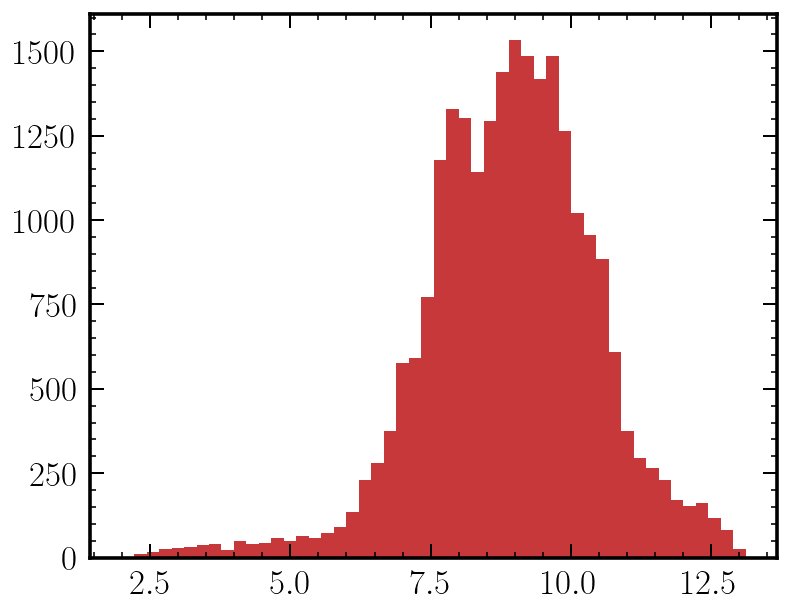

In [ ]:
plt.hist(np.array(clim_xarr['Tmax_std'][0, :, :]).flatten(), bins= 50);

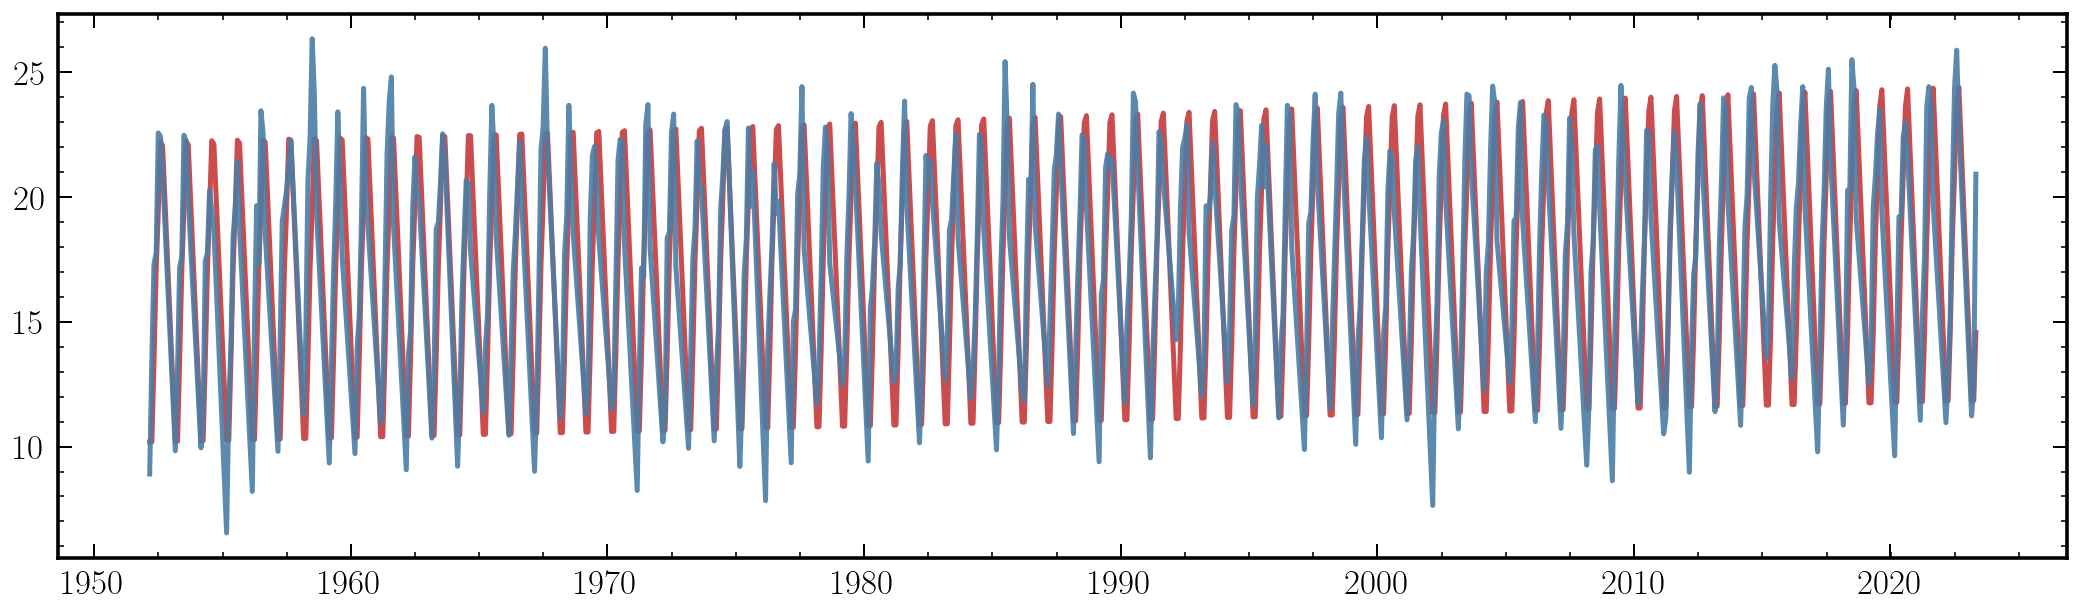

In [ ]:
fig, ax= plt.subplots(figsize= (18, 5))
plt.plot(clim_xarr.time.values, clim_xarr['Tmax_trend'][:, 0, 34])
plt.plot(clim_xarr.time.values, clim_xarr['Tmax'][:, 0, 34]*clim_xarr['Tmax_std'][:, 0, 34] + clim_xarr['Tmax_trend'][:, 0, 34])

In [4]:
target_arr= np.append(np.append(np.arange(5, 855, 12), np.arange(5, 855, 12)+1), np.arange(5, 855, 12)+2) #np.append(, np.arange(5, 855, 12)+3) 
lead1mons_pred_arr= target_arr - 1
lead2mons_pred_arr= target_arr - 2
lead3mons_pred_arr= target_arr - 3
#lead4mons_pred_arr= target_arr - 4
#lead5mons_pred_arr= target_arr - 5

lead1mons_pred_df= clim_df[clim_df['time'].isin(lead1mons_pred_arr)].dropna()[input_var_arr].reset_index().drop(columns= ['index'])
lead2mons_pred_df= clim_df[clim_df['time'].isin(lead2mons_pred_arr)].dropna()[input_var_arr].reset_index().drop(columns= ['index'])
lead3mons_pred_df= clim_df[clim_df['time'].isin(lead3mons_pred_arr)].dropna()[input_var_arr].reset_index().drop(columns= ['index'])
#lead4mons_pred_df= clim_df[clim_df['time'].isin(lead4mons_pred_arr)].dropna()[input_var_arr].reset_index().drop(columns= ['index'])
#lead5mons_pred_df= clim_df[clim_df['time'].isin(lead5mons_pred_arr)].dropna()[input_var_arr].reset_index().drop(columns= ['index'])

tmax_target_df= clim_df[clim_df['time'].isin(target_arr)].dropna()[['Tmax', 'Tmax_trend', 'Tmax_std']].reset_index().drop(columns= ['index']).rename(columns= \
                                                                                {'Tmax': 'Tmax_target', 'Tmax_trend': 'Tmax_target_trend', 'Tmax_std': 'Tmax_target_std'})
prec_target_df= clim_df[clim_df['time'].isin(target_arr)].dropna()[['Prec', 'Prec_trend', 'Prec_std']].reset_index().drop(columns= ['index']).rename(columns= \
                                                                                {'Prec': 'Prec_target', 'Prec_trend': 'Prec_target_trend', 'Prec_std': 'Prec_target_std'})
vpd_target_df= clim_df[clim_df['time'].isin(target_arr)].dropna()[['VPD', 'VPD_trend', 'VPD_std']].reset_index().drop(columns= ['index']).rename(columns= \
                                                                                {'VPD': 'VPD_target', 'VPD_trend': 'VPD_target_trend', 'VPD_std': 'VPD_target_std'})
ffwi_target_df= clim_df[clim_df['time'].isin(target_arr)].dropna()[['FFWI_max7', 'FFWI_max7_trend', 'FFWI_max7_std']].reset_index().drop(columns= ['index']).rename(columns= \
                                                                                {'FFWI_max7': 'FFWI_target', 'FFWI_max7_trend': 'FFWI_target_trend', 'FFWI_max7_std': 'FFWI_target_std'})
tmin_target_df= clim_df[clim_df['time'].isin(target_arr)].dropna()[['Tmin', 'Tmin_trend', 'Tmin_std']].reset_index().drop(columns= ['index']).rename(columns= \
                                                                                {'Tmin': 'Tmin_target', 'Tmin_trend': 'Tmin_target_trend', 'Tmin_std': 'Tmin_target_std'})

lead1mons_df= pd.concat([lead1mons_pred_df, tmax_target_df, prec_target_df, vpd_target_df, tmin_target_df, ffwi_target_df], axis= 1).replace(-999, np.nan)
#lead1mons_df['Elev']= (lead1mons_df['Elev'] - lead1mons_df['Elev'].min())/(lead1mons_df['Elev'].max() - lead1mons_df['Elev'].min())
lead2mons_df= pd.concat([lead2mons_pred_df, tmax_target_df, prec_target_df, vpd_target_df, tmin_target_df, ffwi_target_df], axis= 1).replace(-999, np.nan)
lead3mons_df= pd.concat([lead3mons_pred_df, tmax_target_df, prec_target_df, vpd_target_df, tmin_target_df, ffwi_target_df], axis= 1).replace(-999, np.nan)
#lead4mons_df= pd.concat([lead4mons_pred_df, tmax_target_df, prec_target_df, vpd_target_df, tmin_target_df, ffwi_target_df], axis= 1).replace(-999, np.nan)
#lead5mons_df= pd.concat([lead5mons_pred_df, tmax_target_df, prec_target_df, vpd_target_df, tmin_target_df, ffwi_target_df], axis= 1).replace(-999, np.nan)

pred_arr_dynamic= {'Tmax': ['Tmax', 'Prec', 'RH', 'SM_0_100cm', 'PDSI'], 'Prec': ['Prec', 'Tmax', 'RH', 'SM_0_100cm', 'PDSI', 'CAPE'], \
                   'VPD': ['VPD', 'Tmax', 'Prec', 'RH', 'SM_0_100cm', 'PDSI'], 'FFWI': ['FFWI_max7', 'Tmax', 'Prec', 'RH', 'SM_0_100cm', 'PDSI'], \
                    'Tmin': ['Tmin', 'Tmax', 'Prec', 'RH', 'SM_0_100cm', 'PDSI']}

#### NGBoost training

In [8]:
pred_var_arr= ['Tmax', 'VPD' , 'Prec', 'FFWI', 'Tmin']
run_id_arr= ['normalized_lead1mo_seas_detrended', 'normalized_lead2mo_seas_detrended', 'normalized_lead3mo_seas_detrended'] ##grid_normalized_lead1mo #, 'normalized_lead2mo_detrended', 'normalized_lead3mo_detrended', 'normalized_lead4mo_detrended']
mb_frac= 0.1
train_mons= 792

for pred_var in tqdm(pred_var_arr):
    rseed= np.random.randint(100) #ensures the same random seed for all lead time runs
    for run_id in run_id_arr:
        if 'lead1mo' in run_id.split('_'):
            leadmonsdf= lead1mons_df
            leadsmons_pred_arr= np.sort(lead1mons_pred_arr)
        elif 'lead2mo' in run_id.split('_'):
            leadmonsdf= lead2mons_df
            leadsmons_pred_arr= np.sort(lead2mons_pred_arr)
        elif 'lead3mo' in run_id.split('_'):
            leadmonsdf= lead3mons_df
            leadsmons_pred_arr= np.sort(lead3mons_pred_arr)
        #elif 'lead4mo' in run_id.split('_'):
        #    leadmonsdf= lead4mons_df
        #    leadsmons_pred_arr= np.sort(lead4mons_pred_arr)
        
        X= leadmonsdf[input_var_arr][leadmonsdf.time < train_mons] # train+val:test :: 80:20 #pred_arr_all[pred_var]
        X_scaled= pd.concat([X[pred_arr_dynamic[pred_var]], X[['Elev', 'nino34', 'mei', 'rmm1', 'rmm2']]], axis= 1).replace(np.nan, 0)
        Y_scaled= (leadmonsdf.iloc[X_scaled.index][pred_var + '_target']).replace(0.0, 0.001)
        #Y_scaled= Y - leadmonsdf.iloc[X_scaled.index][pred_var + '_trend_target']
        #Y_scaled= Y_scaled/Y_scaled.std()
        X_train, X_val, Y_train, Y_val = train_test_split(X_scaled, Y_scaled, test_size=0.2)

        poly = PolynomialFeatures(1)
        X_train_poly= poly.fit_transform(X_train)
        X_val_poly= poly.fit_transform(X_val)
        
        ngb = NGBRegressor(minibatch_frac= mb_frac, random_state= rseed, n_estimators= 1000).fit(X_train_poly, Y_train)
        Y_preds = ngb.predict(X_val_poly)
        Y_dists = ngb.pred_dist(X_val_poly)

        # test Mean Squared Error
        test_MSE = mean_squared_error(Y_preds, Y_val)
        print('Test MSE', test_MSE)

        # test Negative Log Likelihood
        test_NLL = -Y_dists.logpdf(Y_val).mean()
        print('Test NLL', test_NLL)

        ngb_path= 'ngb_%s'%pred_var + '_%s'%run_id +'_mb_%.2f.p'%mb_frac 
        file_path = Path.home()/'Desktop/seasonal_fire_pred/sav_files/ngb_mods'/ngb_path
        with file_path.open("wb") as f:
            pickle.dump(ngb, f)

  0%|          | 0/5 [00:00<?, ?it/s]

[iter 0] loss=1.4377 val_loss=0.0000 scale=1.0000 norm=1.0144
[iter 100] loss=1.3169 val_loss=0.0000 scale=1.0000 norm=0.9149
[iter 200] loss=1.2145 val_loss=0.0000 scale=1.0000 norm=0.8600
[iter 300] loss=1.1542 val_loss=0.0000 scale=2.0000 norm=1.6648
[iter 400] loss=1.1110 val_loss=0.0000 scale=1.0000 norm=0.8151
[iter 500] loss=1.0716 val_loss=0.0000 scale=1.0000 norm=0.7979
[iter 600] loss=1.0362 val_loss=0.0000 scale=1.0000 norm=0.7831
[iter 700] loss=1.0084 val_loss=0.0000 scale=1.0000 norm=0.7729
[iter 800] loss=0.9846 val_loss=0.0000 scale=1.0000 norm=0.7652
[iter 900] loss=0.9610 val_loss=0.0000 scale=1.0000 norm=0.7566
Test MSE 0.45644948376911293
Test NLL 0.9408196054877439
[iter 0] loss=1.4379 val_loss=0.0000 scale=1.0000 norm=1.0145
[iter 100] loss=1.3383 val_loss=0.0000 scale=1.0000 norm=0.9359
[iter 200] loss=1.2687 val_loss=0.0000 scale=1.0000 norm=0.8938
[iter 300] loss=1.2158 val_loss=0.0000 scale=1.0000 norm=0.8653
[iter 400] loss=1.1760 val_loss=0.0000 scale=1.0000

 20%|██        | 1/5 [1:39:59<6:39:56, 5999.07s/it]

Test MSE 0.4462267019771664
Test NLL 0.9244939739488615
[iter 0] loss=1.6606 val_loss=0.0000 scale=1.0000 norm=1.2053
[iter 100] loss=1.5549 val_loss=0.0000 scale=1.0000 norm=1.0991
[iter 200] loss=1.4942 val_loss=0.0000 scale=1.0000 norm=1.0546
[iter 300] loss=1.4534 val_loss=0.0000 scale=1.0000 norm=1.0299
[iter 400] loss=1.4173 val_loss=0.0000 scale=1.0000 norm=1.0086
[iter 500] loss=1.3859 val_loss=0.0000 scale=1.0000 norm=0.9894
[iter 600] loss=1.3616 val_loss=0.0000 scale=1.0000 norm=0.9758
[iter 700] loss=1.3368 val_loss=0.0000 scale=1.0000 norm=0.9606
[iter 800] loss=1.3200 val_loss=0.0000 scale=1.0000 norm=0.9525
[iter 900] loss=1.3021 val_loss=0.0000 scale=1.0000 norm=0.9425
Test MSE 0.883247242202206
Test NLL 1.2876676037365196
[iter 0] loss=1.6592 val_loss=0.0000 scale=1.0000 norm=1.2034
[iter 100] loss=1.5457 val_loss=0.0000 scale=1.0000 norm=1.0927
[iter 200] loss=1.4736 val_loss=0.0000 scale=1.0000 norm=1.0400
[iter 300] loss=1.4258 val_loss=0.0000 scale=1.0000 norm=1.01

 40%|████      | 2/5 [3:49:50<5:52:40, 7053.37s/it]

Test MSE 0.8610636011888303
Test NLL 1.2685388700634328
[iter 0] loss=1.4322 val_loss=0.0000 scale=2.0000 norm=2.0166
[iter 100] loss=1.3710 val_loss=0.0000 scale=1.0000 norm=0.9761
[iter 200] loss=1.3460 val_loss=0.0000 scale=1.0000 norm=0.9683
[iter 300] loss=1.3279 val_loss=0.0000 scale=1.0000 norm=0.9620
[iter 400] loss=1.3106 val_loss=0.0000 scale=1.0000 norm=0.9556
[iter 500] loss=1.2995 val_loss=0.0000 scale=1.0000 norm=0.9526
[iter 600] loss=1.2900 val_loss=0.0000 scale=1.0000 norm=0.9492
[iter 700] loss=1.2774 val_loss=0.0000 scale=1.0000 norm=0.9424
[iter 800] loss=1.2723 val_loss=0.0000 scale=2.0000 norm=1.8837
[iter 900] loss=1.2673 val_loss=0.0000 scale=1.0000 norm=0.9409
Test MSE 0.8637865347761963
Test NLL 1.2581631742964532
[iter 0] loss=1.4319 val_loss=0.0000 scale=2.0000 norm=2.0166
[iter 100] loss=1.3609 val_loss=0.0000 scale=2.0000 norm=1.9503
[iter 200] loss=1.3412 val_loss=0.0000 scale=1.0000 norm=0.9710
[iter 300] loss=1.3224 val_loss=0.0000 scale=1.0000 norm=0.9

 60%|██████    | 3/5 [5:59:00<4:05:43, 7371.54s/it]

Test MSE 0.8792628431592219
Test NLL 1.2722236786052648
[iter 0] loss=1.3631 val_loss=0.0000 scale=1.0000 norm=0.9643
[iter 100] loss=1.2997 val_loss=0.0000 scale=1.0000 norm=0.9164
[iter 200] loss=1.2737 val_loss=0.0000 scale=1.0000 norm=0.9071
[iter 300] loss=1.2535 val_loss=0.0000 scale=1.0000 norm=0.8989
[iter 400] loss=1.2378 val_loss=0.0000 scale=1.0000 norm=0.8922
[iter 500] loss=1.2263 val_loss=0.0000 scale=1.0000 norm=0.8877
[iter 600] loss=1.2173 val_loss=0.0000 scale=1.0000 norm=0.8845
[iter 700] loss=1.2100 val_loss=0.0000 scale=1.0000 norm=0.8820
[iter 800] loss=1.2012 val_loss=0.0000 scale=1.0000 norm=0.8777
[iter 900] loss=1.1952 val_loss=0.0000 scale=1.0000 norm=0.8754
Test MSE 0.6847426955082985
Test NLL 1.1893489437205078
[iter 0] loss=1.3605 val_loss=0.0000 scale=1.0000 norm=0.9617
[iter 100] loss=1.3211 val_loss=0.0000 scale=1.0000 norm=0.9327
[iter 200] loss=1.3007 val_loss=0.0000 scale=1.0000 norm=0.9229
[iter 300] loss=1.2853 val_loss=0.0000 scale=1.0000 norm=0.9

 80%|████████  | 4/5 [8:08:14<2:05:22, 7522.47s/it]

Test MSE 0.7211531832082405
Test NLL 1.2274739605902487
[iter 0] loss=1.4296 val_loss=0.0000 scale=1.0000 norm=1.0080
[iter 100] loss=1.2670 val_loss=0.0000 scale=1.0000 norm=0.8793
[iter 200] loss=1.1673 val_loss=0.0000 scale=1.0000 norm=0.8324
[iter 300] loss=1.0789 val_loss=0.0000 scale=1.0000 norm=0.7963
[iter 400] loss=1.0234 val_loss=0.0000 scale=1.0000 norm=0.7785
[iter 500] loss=0.9756 val_loss=0.0000 scale=1.0000 norm=0.7607
[iter 600] loss=0.9371 val_loss=0.0000 scale=1.0000 norm=0.7493
[iter 700] loss=0.9055 val_loss=0.0000 scale=1.0000 norm=0.7403
[iter 800] loss=0.8743 val_loss=0.0000 scale=1.0000 norm=0.7279
[iter 900] loss=0.8484 val_loss=0.0000 scale=1.0000 norm=0.7203
Test MSE 0.37188774051885437
Test NLL 0.8246761084398573
[iter 0] loss=1.4314 val_loss=0.0000 scale=1.0000 norm=1.0099
[iter 100] loss=1.3093 val_loss=0.0000 scale=1.0000 norm=0.9177
[iter 200] loss=1.2323 val_loss=0.0000 scale=1.0000 norm=0.8748
[iter 300] loss=1.1738 val_loss=0.0000 scale=1.0000 norm=0.

100%|██████████| 5/5 [10:17:06<00:00, 7405.38s/it] 

Test MSE 0.33590877626997107
Test NLL 0.7680877956974602


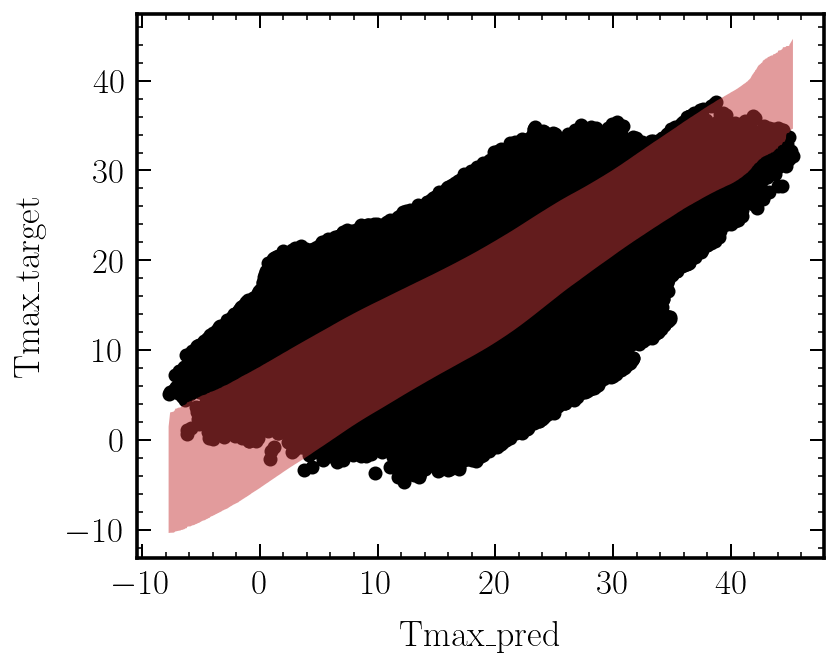

In [6]:
plt.scatter(X_val_poly[:, 1]*X.iloc[X_val.index][pred_var + '_std'] + X.iloc[X_val.index][pred_var + '_trend'], Y_val*X.iloc[X_val.index][pred_var + '_std'] + X.iloc[X_val.index][pred_var + '_trend'], color= 'black')

Y_pred_low_1sig= (Y_dists.params['loc'] - 1.96 * Y_dists.params['scale'])*X.iloc[X_val.index][pred_var + '_std'] + X.iloc[X_val.index][pred_var + '_trend']
Y_pred_high_1sig= (Y_dists.params['loc'] + 1.96 * Y_dists.params['scale'])*X.iloc[X_val.index][pred_var + '_std'] + X.iloc[X_val.index][pred_var + '_trend']
plt.fill_between(np.sort(X_val_poly[:, 1]*X.iloc[X_val.index][pred_var + '_std'] + X.iloc[X_val.index][pred_var + '_trend']), np.sort(Y_pred_low_1sig), np.sort(Y_pred_high_1sig), alpha= 0.5)
plt.xlabel(r'%s_pred'%pred_var, fontsize= 18)
plt.ylabel(r'%s_target'%pred_var, fontsize= 18)
plt.show()

#### NGBoost predictions

In [5]:
pred_var_arr= ['Tmax', 'VPD' , 'Prec', 'FFWI', 'Tmin']
run_id_arr= ['normalized_lead1mo_seas_detrended', 'normalized_lead2mo_seas_detrended', 'normalized_lead3mo_seas_detrended'] #'normalized_lead1mo_seas_detrended', 'normalized_lead2mo_seas_detrended', 
mb_frac= 0.1 
tmax_xr= xarray.open_dataarray('../data/12km/climate/primary/tmax.nc') # for getting the lat/lon coordinates
ind_nan= clim_df.groupby('time').get_group(list(clim_df.groupby('time').groups.keys())[0]).dropna().index
len_xcoord= len(tmax_xr.X)
len_ycoord= len(tmax_xr.Y)

for pred_var in tqdm(pred_var_arr):
    for run_id in run_id_arr:
        if 'lead1mo' in run_id.split('_'):
            leadmonsdf= lead1mons_df
            leadsmons_pred_arr= np.sort(lead1mons_pred_arr)
        elif 'lead2mo' in run_id.split('_'):
            leadmonsdf= lead2mons_df
            leadsmons_pred_arr= np.sort(lead2mons_pred_arr)
        elif 'lead3mo' in run_id.split('_'):
            leadmonsdf= lead3mons_df
            leadsmons_pred_arr= np.sort(lead3mons_pred_arr)
        #elif 'lead4mo' in run_id.split('_'):
        #    leadmonsdf= lead4mons_df
        #    leadsmons_pred_arr= np.sort(lead4mons_pred_arr)
            
        ngb_path= 'ngb_%s'%pred_var + '_%s'%run_id + '_mb_%.2f.p'%(mb_frac)
        file_path = Path.home()/'Desktop/seasonal_fire_pred/sav_files/ngb_mods'/ngb_path
        with file_path.open("rb") as f:
            ngb= pickle.load(f)

        Y_dist_loc= []
        Y_dist_scale= []

        leadmonsdf_groups= leadmonsdf.groupby(['time'], as_index= False)
        for m in leadsmons_pred_arr:
            X_test= leadmonsdf_groups.get_group(m)[input_var_arr]
            Y_test_std= leadmonsdf_groups.get_group(m)[pred_var + '_target_std']  # ensure that Y is always the target variable and not a predictor
            Y_test_mean= leadmonsdf_groups.get_group(m)[pred_var + '_target_trend']

            X_test_scaled= pd.concat([X_test[pred_arr_dynamic[pred_var]], X_test[['Elev', 'nino34', 'mei', 'rmm1', 'rmm2']]], axis= 1).replace(np.nan, 0)
            poly = PolynomialFeatures(1)
            X_test_poly= poly.fit_transform(X_test_scaled)
                
            tmplocarr= np.ones(len_xcoord*len_ycoord)*np.nan
            tmpsigarr= np.ones(len_xcoord*len_ycoord)*np.nan
            tmplocarr[ind_nan]= ngb.pred_dist(X_test_poly).params['loc']*Y_test_std + Y_test_mean
            tmpsigarr[ind_nan]= ngb.pred_dist(X_test_poly).params['scale']*Y_test_std
            Y_dist_loc.append(tmplocarr)
            Y_dist_scale.append(tmpsigarr)

        # convert Y_dist_loc and Y_dist_scale to xarray with X and Y dimensions equal to len_ycoord and len_xcoord
        Y_dist_loc_xr= xarray.DataArray(np.array(Y_dist_loc).reshape(len(target_arr), len_ycoord, len_xcoord), \
                                                    coords= {'time': np.sort(target_arr), 'Y': tmax_xr.Y, 'X': tmax_xr.X}, dims= ['time', 'Y', 'X'])
        Y_dist_scale_xr= xarray.DataArray(np.array(Y_dist_scale).reshape(len(target_arr), len_ycoord, len_xcoord), \
                                                    coords= {'time': np.sort(target_arr), 'Y': tmax_xr.Y, 'X': tmax_xr.X}, dims= ['time', 'Y', 'X'])
        Y_dist_loc_xr.to_netcdf('../sav_files/ngb_pred_files/%s'%pred_var + '_%s'%mb_frac + '_%s_ngb_loc.nc'%run_id)
        Y_dist_scale_xr.to_netcdf('../sav_files/ngb_pred_files/%s'%pred_var + '_%s'%mb_frac + '_%s_ngb_scale.nc'%run_id)

100%|██████████| 5/5 [2:07:26<00:00, 1529.35s/it]


## Plotting ML forecasts

In [47]:
pred_var= 'Prec'
unit_arr= {'Tmax': 'degC', 'Prec': 'mm' ,'VPD': 'hPa', 'FFWI': 'Intensity', 'Tmin': 'degC'}
cmap_arr= {'Tmax': 'coolwarm', 'Prec': 'BrBG', 'VPD': 'Reds', 'FFWI': 'coolwarm', 'Tmin': 'coolwarm'}
mb_frac= 0.1
run_id= 'normalized_lead1mo_seas_detrended'

Y_dist_loc_xr= xarray.open_dataarray('../sav_files/ngb_pred_files/%s'%pred_var + '_%s'%mb_frac + '_%s_ngb_loc.nc'%run_id)
Y_dist_scale_xr= xarray.open_dataarray('../sav_files/ngb_pred_files/%s'%pred_var + '_%s'%mb_frac + '_%s_ngb_scale.nc'%run_id)
Y_obs_xr= xarray.open_dataarray('../sav_files/ngb_pred_files/%s'%pred_var + '_obs.nc')
Y_obs_xr= Y_obs_xr[Y_obs_xr.time.isin(target_arr), :, :]

lat_long_fire_grid= coord_transform(Y_dist_loc_xr['X'][:].data, Y_dist_loc_xr['Y'][:].data, input_crs= 'EPSG:5070', output_crs= 'EPSG:4326')
jun_arr= np.arange(5, 855, 12)
jul_arr= jun_arr + 1
aug_arr= jun_arr + 2
sep_arr= jun_arr + 3

jun_jul_baseline= np.append(jun_arr[0:57], jul_arr[0:57]) #1952 -- 2010: [0:57]; 2000 -- 2020: [48:69]
aug_sep_baseline= np.append(aug_arr[0:57], sep_arr[0:57])
jun_jul_test= np.append(jun_arr[65:], jul_arr[65:])
aug_sep_test= np.append(aug_arr[65:], sep_arr[65:])

In [48]:
# for comparing skill across different lead times

run_id_arr= ['normalized_lead1mo_seas_detrended', 'normalized_lead2mo_seas_detrended', 'normalized_lead3mo_seas_detrended']
# mb_frac= 0.1
pearson_test_r_arr= []

for r_id in run_id_arr:
    Y_pred_xr= xarray.open_dataarray('../sav_files/ngb_pred_files/%s'%pred_var + '_%s'%mb_frac + '_%s_ngb_loc.nc'%r_id)
    pearson_test_r_arr.append(stats.pearsonr(np.mean(Y_pred_xr[197:, :, :], axis= (1,2)), np.mean(Y_obs_xr[197:, :, :], axis= (1,2)))[0]) #232

pearson_test_r_arr

[0.3557700760251637, -0.28689281313576614, 0.012195042264629256]

In [13]:
grid_all= np.where(~np.isnan(Y_dist_loc_xr[0, :, :])) # choose random non nan grid cell for plotting
pearson_r_arr= [stats.pearsonr(Y_dist_loc_xr[:, grid_all[0][g], grid_all[1][g]], Y_obs_xr[:, grid_all[0][g], grid_all[1][g]])[0] for g in tqdm(range(len(grid_all[0])))]

best_ind_arr= np.argsort(pearson_r_arr)[-3:]
worst_ind_arr= np.argsort(pearson_r_arr)[:3]
rand_ind_arr= np.random.randint(0, len(grid_all[0]), 3)

100%|██████████| 23903/23903 [02:40<00:00, 148.85it/s]


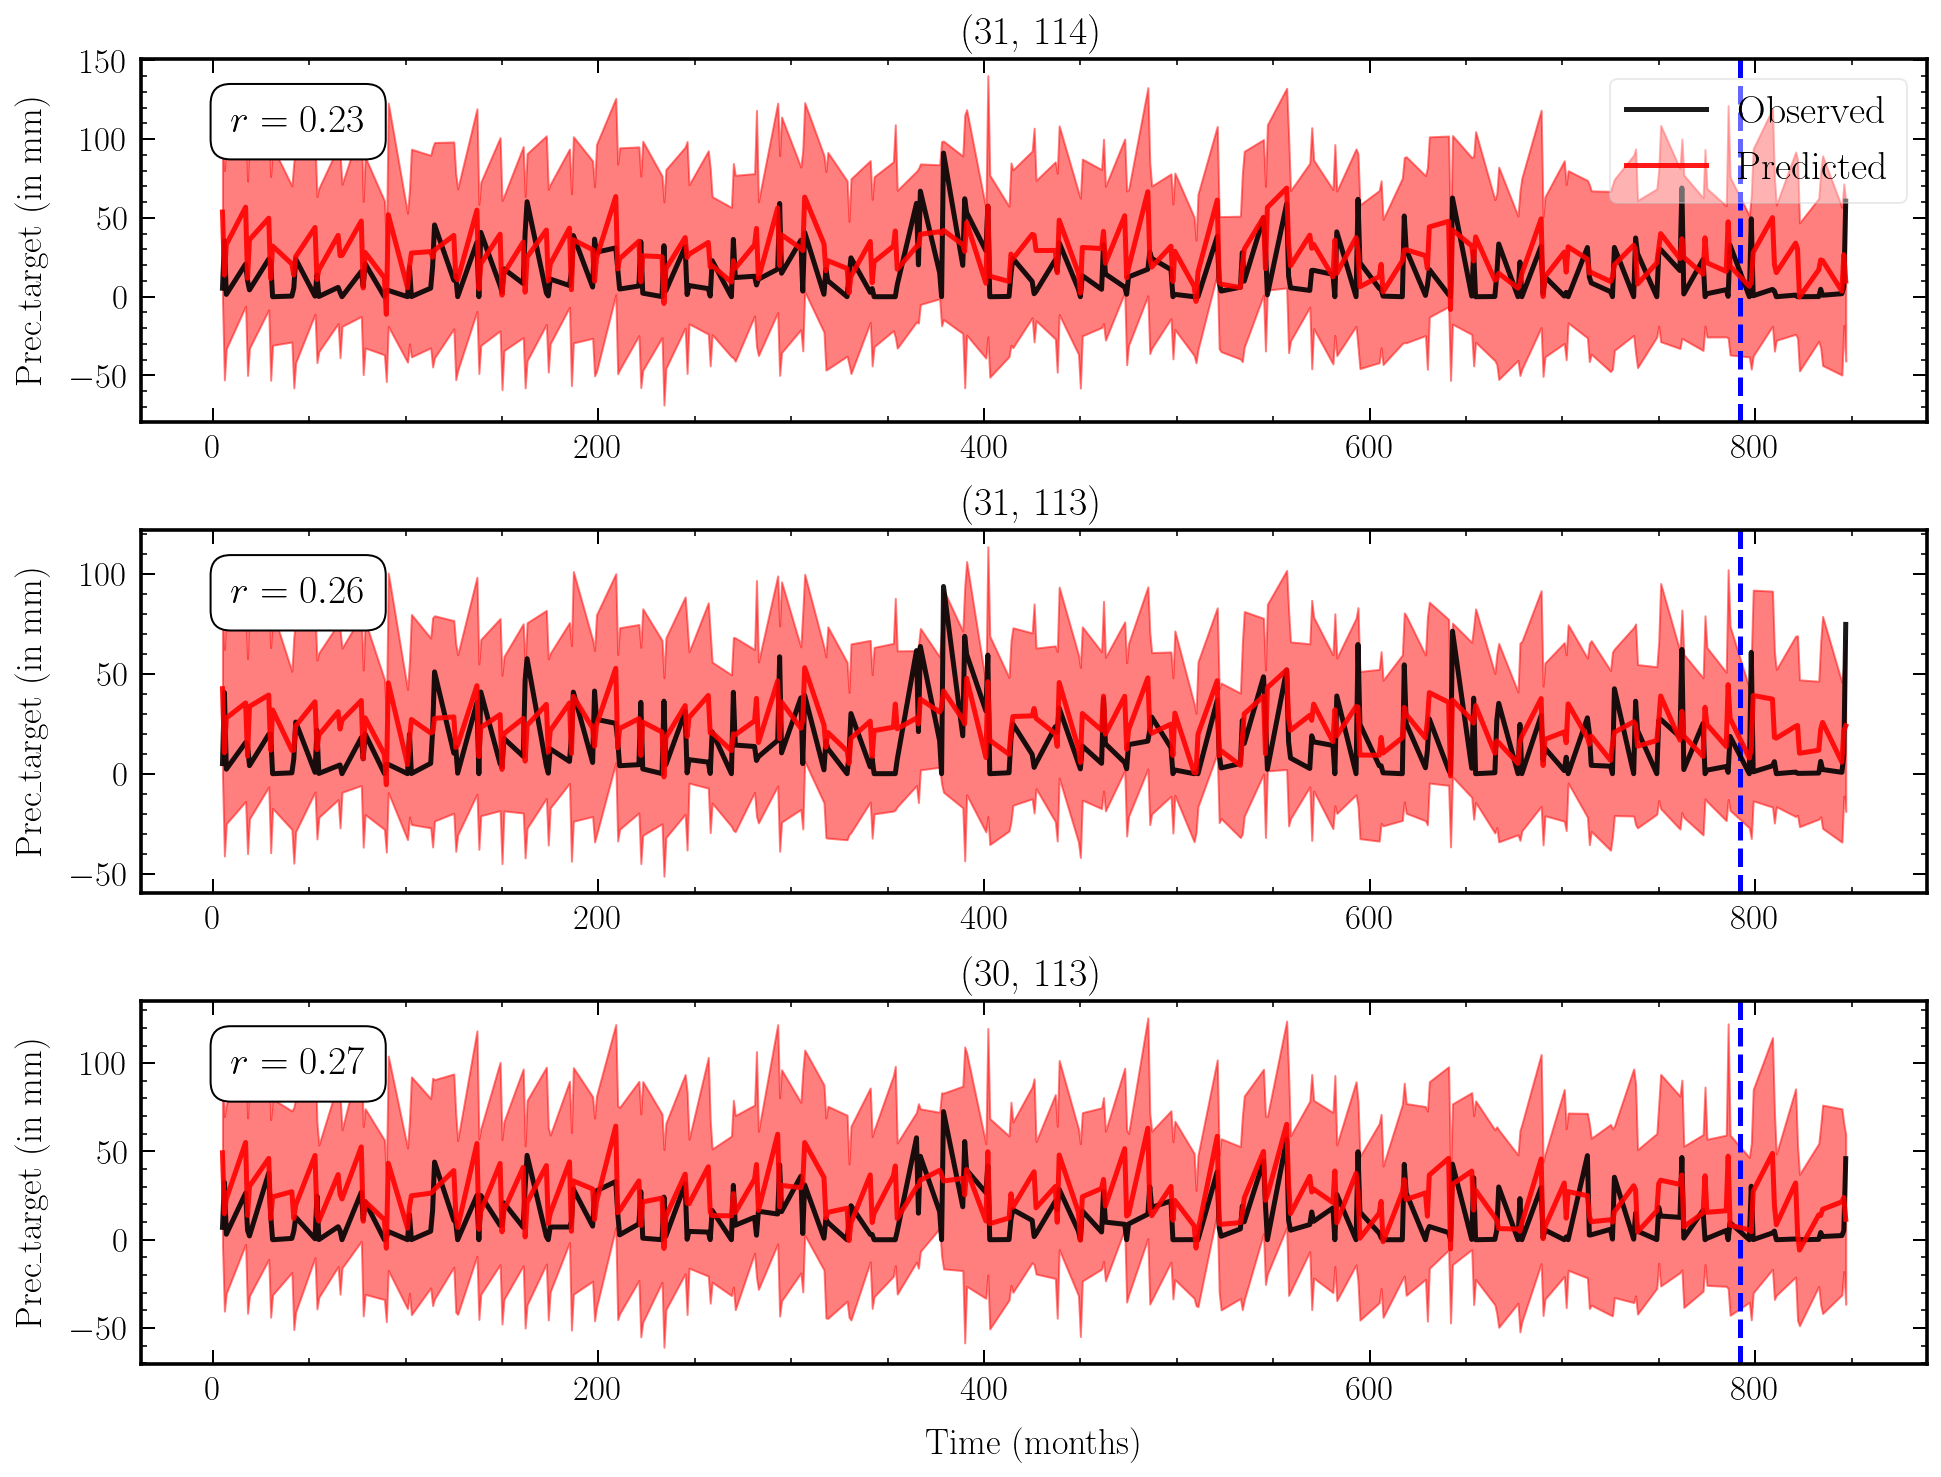

In [49]:
fig, ax= plt.subplots(3, 1, figsize=(16, 12))
config= 'best'

if config == 'best':
    ind_y_arr= grid_all[0][best_ind_arr]
    ind_x_arr= grid_all[1][best_ind_arr]
elif config == 'worst':
    ind_y_arr= grid_all[0][worst_ind_arr]
    ind_x_arr= grid_all[1][worst_ind_arr]
elif config == 'random':
    ind_y_arr= grid_all[0][rand_ind_arr]
    ind_x_arr= grid_all[1][rand_ind_arr]

for i in range(3):
    pearson_r= stats.pearsonr(Y_dist_loc_xr[:, ind_y_arr[i], ind_x_arr[i]], Y_obs_xr[:, ind_y_arr[i], ind_x_arr[i]])[0]
    Y_pred_low_1sig= Y_dist_loc_xr[:, ind_y_arr[i], ind_x_arr[i]] - Y_dist_scale_xr[:, ind_y_arr[i], ind_x_arr[i]]
    Y_pred_high_1sig= Y_dist_loc_xr[:, ind_y_arr[i], ind_x_arr[i]] + Y_dist_scale_xr[:, ind_y_arr[i], ind_x_arr[i]]

    ax[i].plot(Y_obs_xr.time, Y_obs_xr[:, ind_y_arr[i], ind_x_arr[i]], color= 'black', label= 'Observed')
    ax[i].plot(Y_obs_xr.time, Y_dist_loc_xr[:, ind_y_arr[i], ind_x_arr[i]], color= 'red', label= 'Predicted')
    ax[i].fill_between(Y_obs_xr.time, Y_pred_low_1sig, Y_pred_high_1sig, color= 'red', alpha= 0.5)

    if i== 2:
        ax[i].set_xlabel(r'Time (months)', fontsize= 18);
    ax[i].set_ylabel(pred_var + '_target ' + '(in %s)'%(unit_arr[pred_var]), fontsize= 18);
    ax[i].text(0.05, 0.8, r'$r = %.2f$'%pearson_r, fontsize= 20, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax[i].transAxes)
    #ax[i].set_ylim(10, 40);
    if i== 0:
        ax[i].legend(loc='upper right', frameon= True, fontsize= 20);
    ax[i].set_title(r'(%d, '%ind_x_arr[i] + '%d)'%ind_y_arr[i], fontsize= 20);
    fig.subplots_adjust(hspace= 0.3)
    ax[i].axvline(x= 792, color= 'blue', lw= 2.5, linestyle= '--', zorder= 1)
    #plt.savefig('../plots/%s'%pred_var + '_ngboost_%s'%config + '_prediction_%s.pdf'%run_id, bbox_inches='tight', dpi= 300);

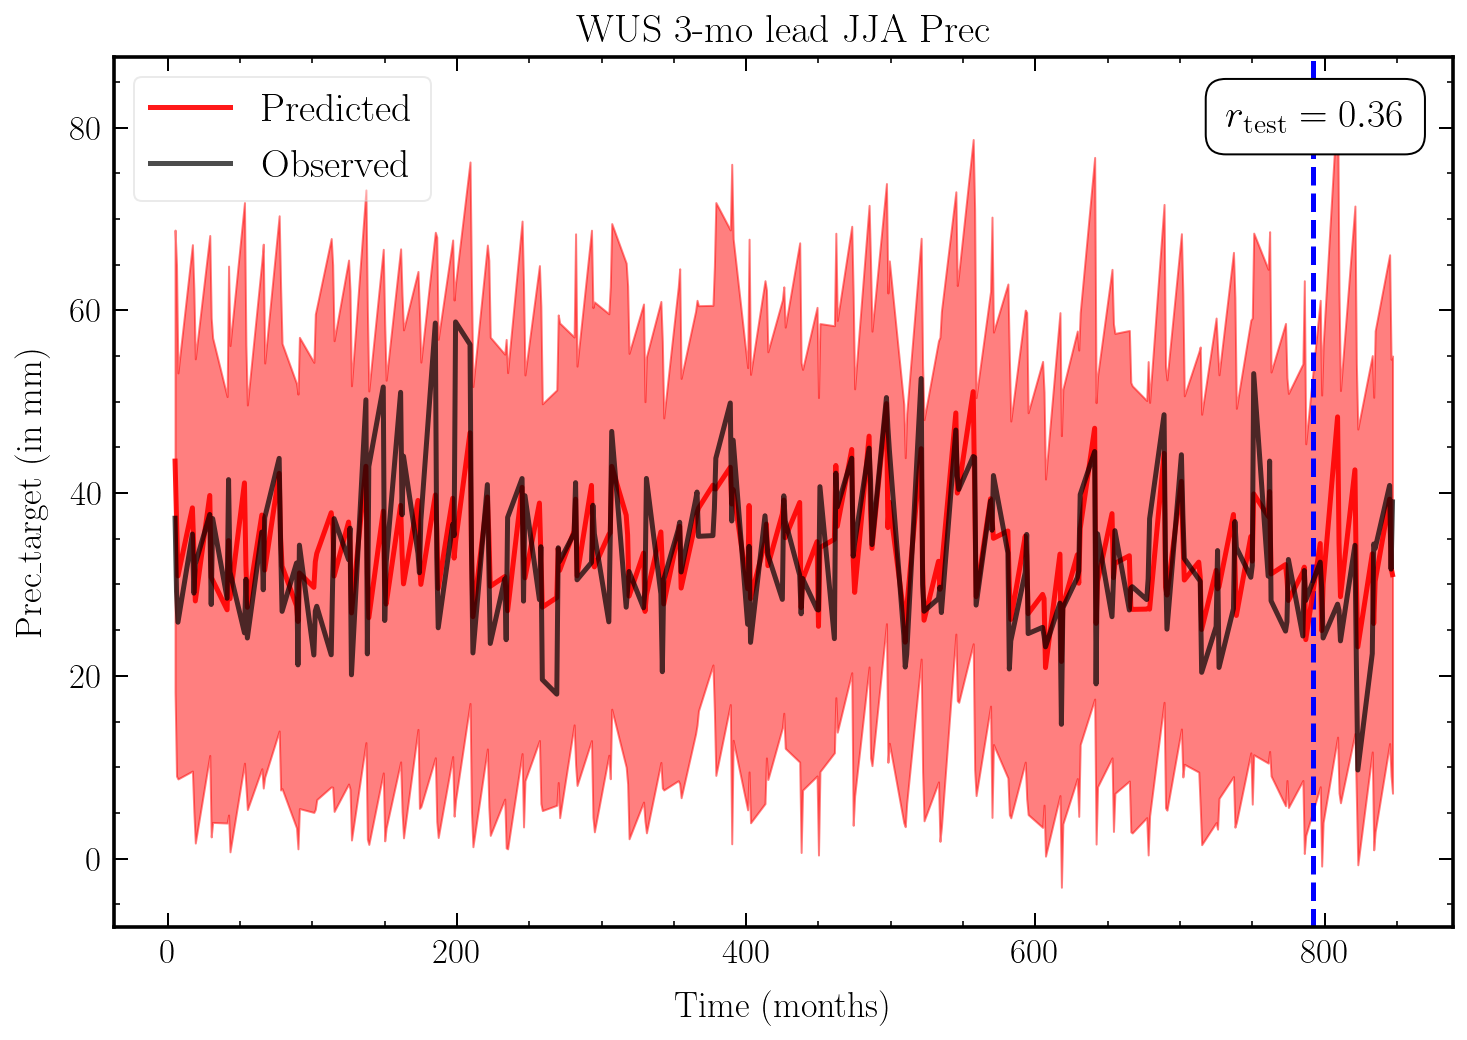

In [50]:
fig, ax= plt.subplots(1, 1, figsize=(12, 8))

plt.plot(Y_dist_loc_xr.time, np.mean(Y_dist_loc_xr, axis= (1,2)), color= 'red', label= 'Predicted')
plt.fill_between(Y_dist_loc_xr.time, np.mean(Y_dist_loc_xr, axis= (1,2)) - np.mean(Y_dist_scale_xr, axis= (1,2)), \
                                                np.mean(Y_dist_loc_xr, axis= (1,2)) + np.mean(Y_dist_scale_xr, axis= (1,2)), color= 'red', alpha= 0.5)
plt.plot(Y_dist_loc_xr.time, np.mean(Y_obs_xr, axis= (1,2)), color= 'black', label= 'Observed', alpha= 0.7)

pearson_train_r= stats.pearsonr(np.mean(Y_dist_loc_xr[:197, :, :], axis= (1,2)), np.mean(Y_obs_xr[:197, :, :], axis= (1,2)))[0] #232
pearson_test_r= stats.pearsonr(np.mean(Y_dist_loc_xr[197:, :, :], axis= (1,2)), np.mean(Y_obs_xr[197:, :, :], axis= (1,2)))[0]

ax.set_xlabel(r'Time (months)', fontsize= 18);
ax.set_ylabel(pred_var + '_target ' + '(in %s)'%(unit_arr[pred_var]), fontsize= 18);
ax.text(0.83, 0.92, r'$r_{\rm test} = %.2f$'%pearson_test_r, fontsize= 20, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
        transform=ax.transAxes)
#ax.text(0.83, 0.92, r'$r_{\rm test} = %.2f$'%pearson_test_r, fontsize= 20, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
#        transform=ax.transAxes)
ax.legend(loc='upper left', frameon= True, fontsize= 20);
ax.set_title(r'WUS 3-mo lead JJA %s'%pred_var, fontsize= 20);
ax.axvline(x= 792, color= 'blue', lw= 2.5, linestyle= '--', zorder= 1)
#plt.savefig('../plots/%s'%pred_var + '_ngboost_wus_%s'%mb_frac + '_%s.pdf'%run_id, bbox_inches='tight', dpi= 300);

In [51]:
pred_anom_jj_xarr= Y_dist_loc_xr[Y_dist_loc_xr.time.isin(jun_jul_test), :, :] - np.mean(Y_dist_loc_xr[Y_dist_loc_xr.time.isin(jun_jul_baseline), :, :], axis= 0)
obs_anom_jj_xarr= Y_obs_xr[Y_obs_xr.time.isin(jun_jul_test), :, :] - np.mean(Y_obs_xr[Y_obs_xr.time.isin(jun_jul_baseline), :, :], axis= 0)
pred_anom_as_xarr= Y_dist_loc_xr[Y_dist_loc_xr.time.isin(aug_sep_test), :, :] - np.mean(Y_dist_loc_xr[Y_dist_loc_xr.time.isin(aug_sep_baseline), :, :], axis= 0)
obs_anom_as_xarr= Y_obs_xr[Y_obs_xr.time.isin(aug_sep_test), :, :] - np.mean(Y_obs_xr[Y_obs_xr.time.isin(aug_sep_baseline), :, :], axis= 0)


# calculate cosine similarity between predicted and observed anomalies
cos_sim_jj_xarr= xarray.dot(pred_anom_jj_xarr, obs_anom_jj_xarr, dims= ['time'])/(np.sqrt(xarray.dot(pred_anom_jj_xarr, pred_anom_jj_xarr, dims= ['time'])) * \
                                                                                                            np.sqrt(xarray.dot(obs_anom_jj_xarr, obs_anom_jj_xarr, dims= ['time'])))
cos_sim_as_xarr= xarray.dot(pred_anom_as_xarr, obs_anom_as_xarr, dims= ['time'])/(np.sqrt(xarray.dot(pred_anom_as_xarr, pred_anom_as_xarr, dims= ['time'])) * \
                                                                                                            np.sqrt(xarray.dot(obs_anom_as_xarr, obs_anom_as_xarr, dims= ['time'])))

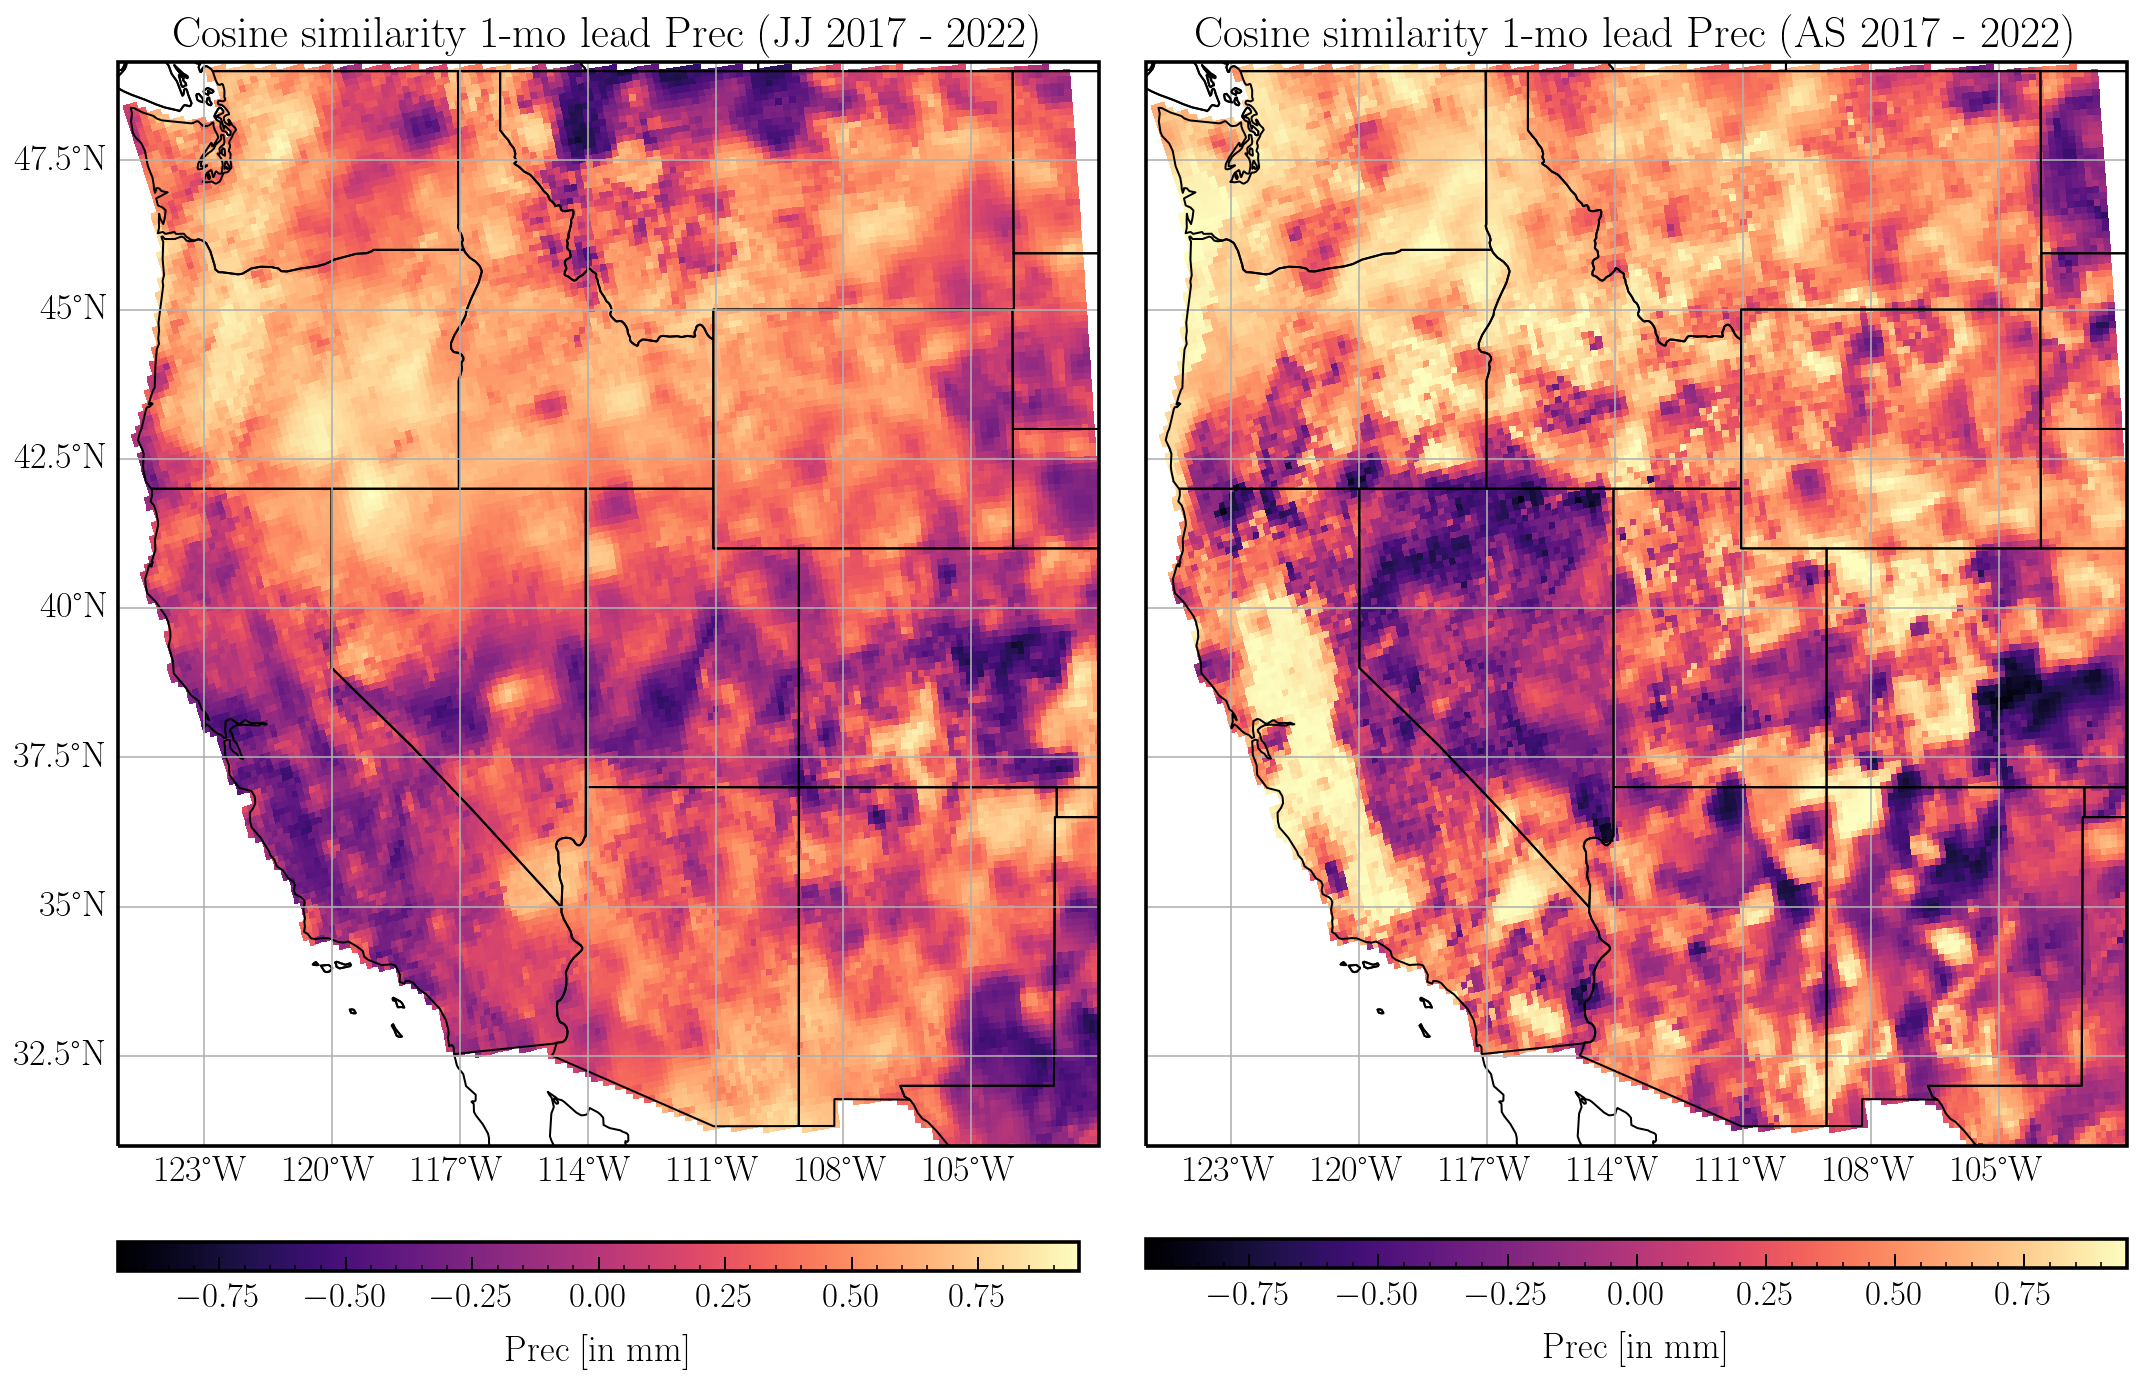

In [52]:
extent = [-125, -102, 31, 49] 
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
#colors= np.random.rand(14)

fig= plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 4)

ax= fig.add_subplot(gs[0:2, 0:2], projection=ccrs.PlateCarree())
ax.set_extent(extent);
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax.add_feature(cfeature.STATES, edgecolor='black');

CS= ax.pcolormesh(lat_long_fire_grid[1], lat_long_fire_grid[0], cos_sim_jj_xarr, vmin= -0.95, vmax= 0.95, cmap=plt.cm.magma) 
cax= fig.add_axes([ax.get_position().x0,ax.get_position().y0 - 0.2, ax.get_position().width, 0.02])
cbar= fig.colorbar(CS, cax= cax, orientation= 'horizontal', shrink= 0.7)
cbar.set_label(r'%s '%pred_var + '[in  %s]'%unit_arr[pred_var], size= 18)

gl= ax.gridlines(draw_labels=True);
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
gl.top_labels = False
gl.right_labels = False
ax.set_aspect(1.4/1) 
ax.set_title(r'Cosine similarity 1-mo lead %s (JJ 2017 - 2022)'%pred_var, fontsize= 22);

fig.subplots_adjust(wspace= 0.1)

ax0= fig.add_subplot(gs[0:2, 2:], projection=ccrs.PlateCarree())
ax0.set_extent(extent);
ax0.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax0.add_feature(cfeature.STATES, edgecolor='black', zorder= 10);

gl0= ax0.gridlines(draw_labels=True);
gl0.xlabel_style = {'size': 18, 'color': 'black'}
gl0.ylabel_style = {'size': 18, 'color': 'black'}
gl0.top_labels = False
gl0.left_labels = False
gl0.right_labels = False
ax0.set_aspect(1.4/1) 

CS0= ax0.pcolormesh(lat_long_fire_grid[1], lat_long_fire_grid[0], cos_sim_as_xarr, vmin= -0.95, vmax= 0.95, cmap=plt.cm.magma) 
cax0= fig.add_axes([ax0.get_position().x0,ax0.get_position().y0 - 0.085, ax0.get_position().width, 0.02])
cbar0= fig.colorbar(CS0, cax= cax0, orientation= 'horizontal', shrink= 0.7)
cbar0.set_label(r'%s '%pred_var + '[in  %s]'%unit_arr[pred_var], size= 18)
ax0.set_title(r'Cosine similarity 1-mo lead %s (AS 2017 - 2022)'%pred_var, fontsize= 22);
plt.savefig('../plots/cosine_similarity/%s'%pred_var + '_cosine_sim_wus_%s.pdf'%run_id, bbox_inches='tight', dpi= 200);

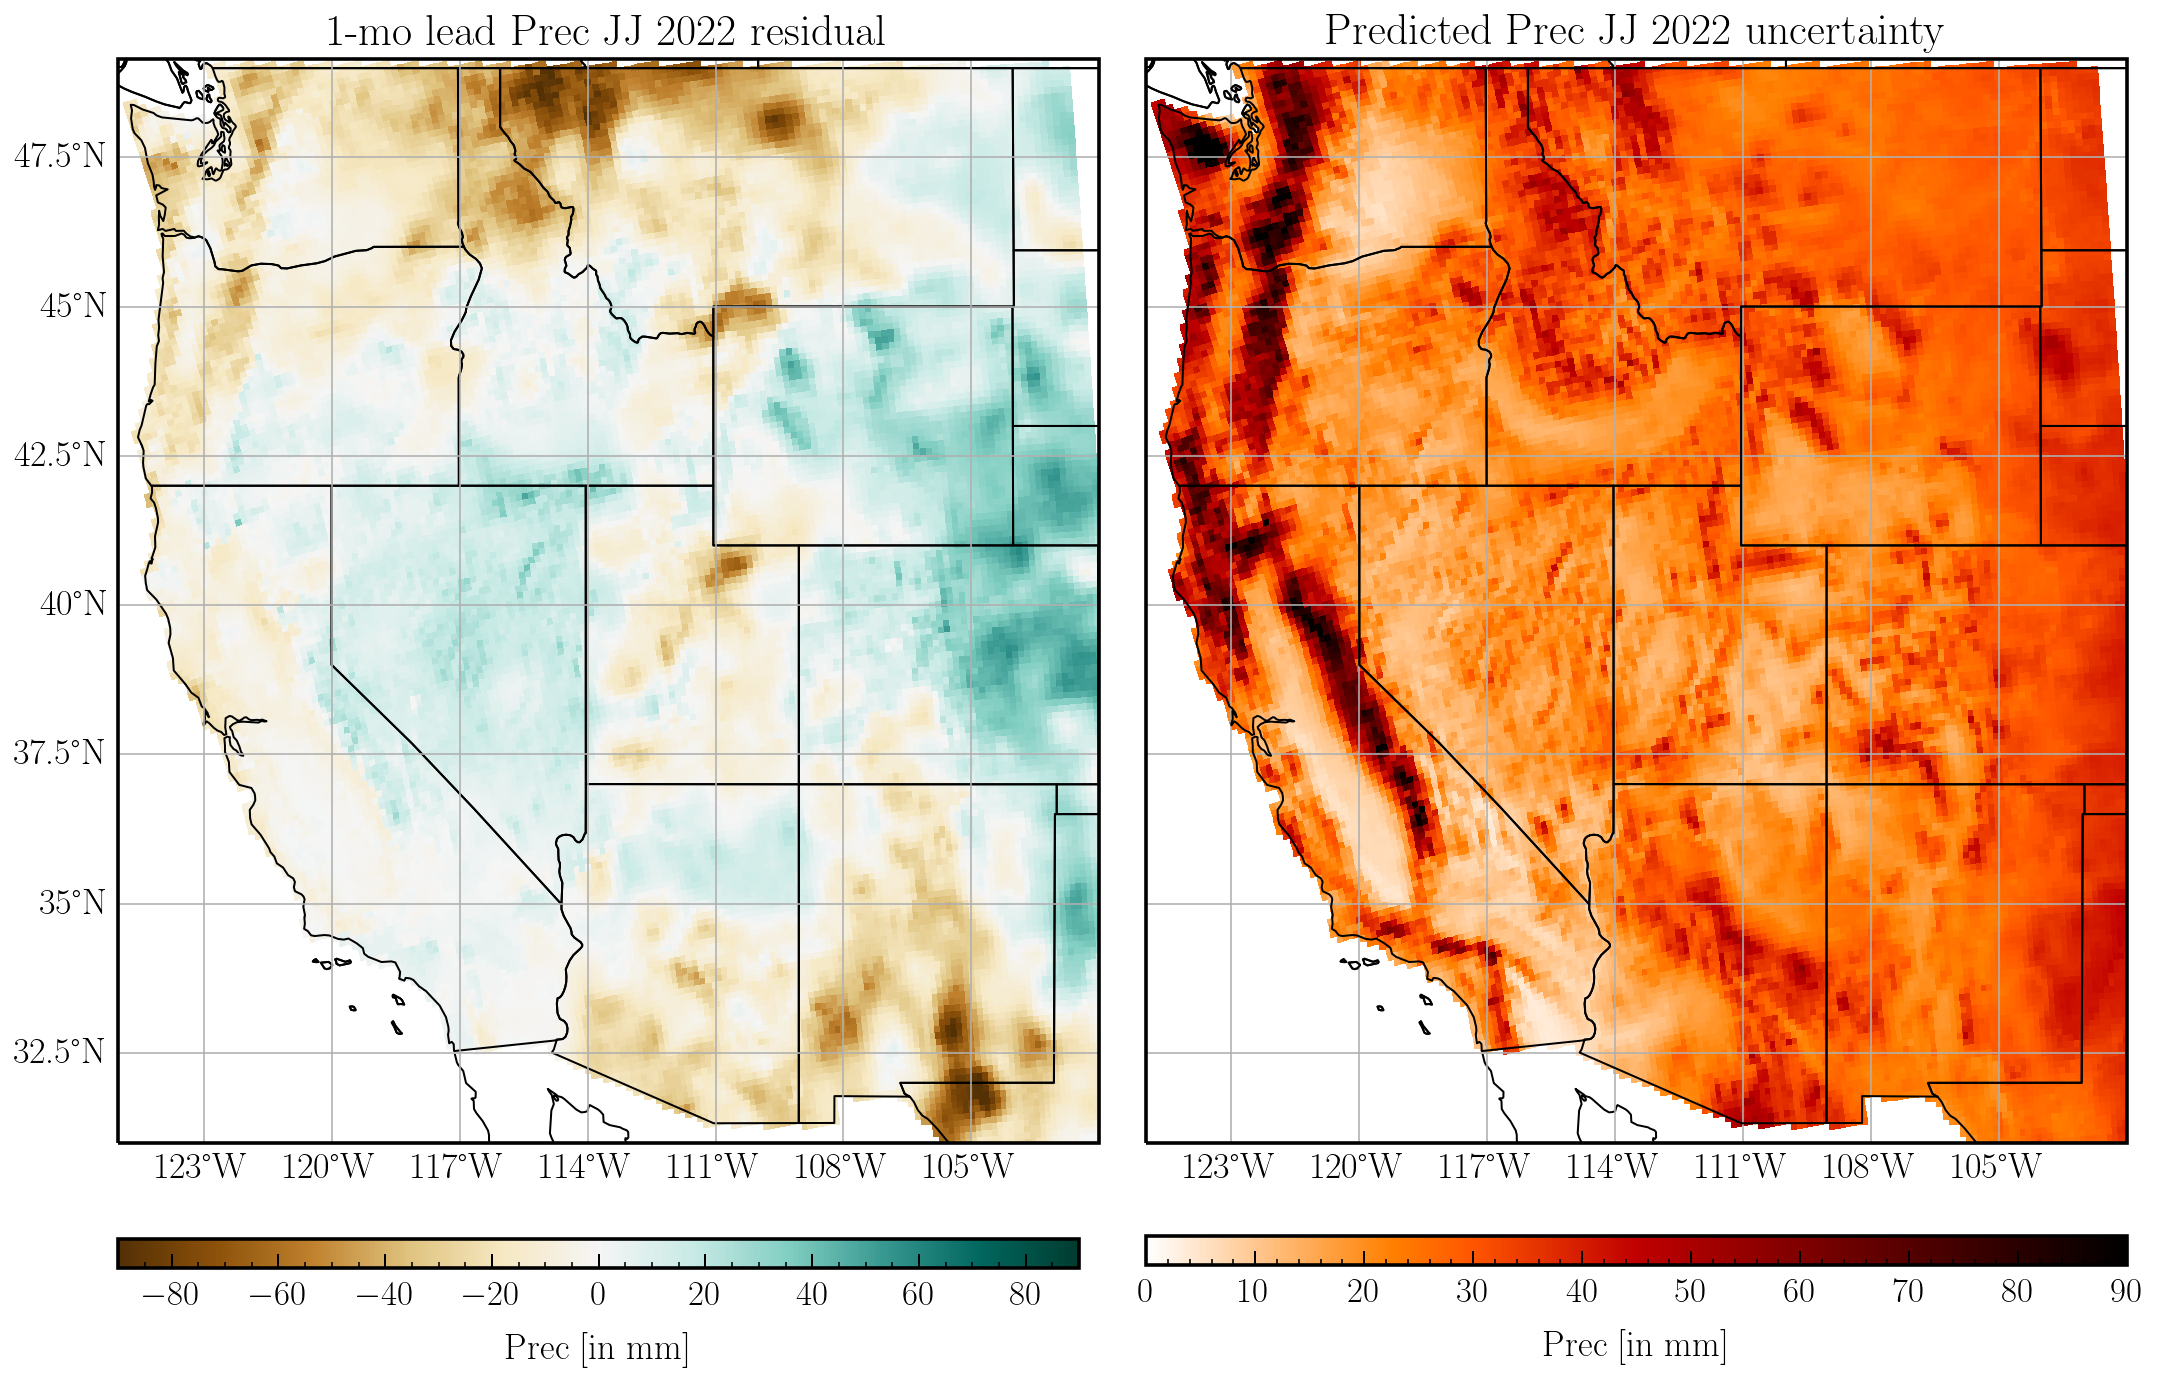

In [60]:
extent = [-125, -102, 31, 49] 
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
#colors= np.random.rand(14)
vmin_pred= -90
vmax_pred= 90

fig= plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 4)

ax= fig.add_subplot(gs[0:2, 0:2], projection=ccrs.PlateCarree())
ax.set_extent(extent);
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax.add_feature(cfeature.STATES, edgecolor='black');

CS= ax.pcolormesh(lat_long_fire_grid[1], lat_long_fire_grid[0], np.mean(Y_dist_loc_xr[-4:-2, :, :], axis= 0) - np.mean(Y_obs_xr[-4:-2, :, :], axis= 0), vmin= vmin_pred, vmax= vmax_pred, cmap= cmap_arr['Prec']) # normalized fire probability summed over all months  
#trend --> xarray.DataArray(data= np.mean(clim_xarr['Tmax_trend'][-12:-10, :, :] + clim_xarr['Tmax_std'][-12:-10, :, :], axis= 0).values, coords= {'Y': tmax_xr.Y, 'X': tmax_xr.X}, dims= ['Y', 'X'])
#climatology --> np.mean(Y_obs_xr[Y_obs_xr.time.isin(jun_jul_baseline), :, :], axis= 0)
cax= fig.add_axes([ax.get_position().x0,ax.get_position().y0 - 0.2, ax.get_position().width, 0.02])
cbar= fig.colorbar(CS, cax= cax, orientation= 'horizontal', shrink= 0.7)
cbar.set_label(r'%s '%pred_var + '[in  %s]'%unit_arr[pred_var], size= 18)

gl= ax.gridlines(draw_labels=True);
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
gl.top_labels = False
gl.right_labels = False
ax.set_aspect(1.4/1) 
ax.set_title(r'1-mo lead %s JJ 2022 residual'%pred_var, fontsize= 22);  #3-mo lead

fig.subplots_adjust(wspace= 0.1)

ax0= fig.add_subplot(gs[0:2, 2:], projection=ccrs.PlateCarree())
ax0.set_extent(extent);
ax0.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax0.add_feature(cfeature.STATES, edgecolor='black', zorder= 10);

gl0= ax0.gridlines(draw_labels=True);
gl0.xlabel_style = {'size': 18, 'color': 'black'}
gl0.ylabel_style = {'size': 18, 'color': 'black'}
gl0.top_labels = False
gl0.left_labels = False
gl0.right_labels = False
ax0.set_aspect(1.4/1) 

CS0= ax0.pcolormesh(lat_long_fire_grid[1], lat_long_fire_grid[0], np.mean(Y_dist_scale_xr[-4:-2, :, :], axis= 0), vmin= 0, vmax= vmax_pred, cmap=plt.cm.gist_heat_r) # normalized fire probability summed over all months #
cax0= fig.add_axes([ax0.get_position().x0,ax0.get_position().y0 - 0.085, ax0.get_position().width, 0.02])
cbar0= fig.colorbar(CS0, cax= cax0, orientation= 'horizontal', shrink= 0.7)
cbar0.set_label(r'%s '%pred_var + '[in  %s]'%unit_arr[pred_var], size= 18)
ax0.set_title(r'Predicted %s JJ 2022 uncertainty'%pred_var, fontsize= 22);
plt.savefig('../plots/residual_plots/%s'%pred_var + '_jj22_spatial_residual_wus_%s.pdf'%run_id, bbox_inches='tight', dpi= 200);

## Feature importance

In [45]:
pred_var= 'Prec'
run_id= 'normalized_lead1mo_seas_detrended'
mb_frac= 0.1

X_features= pd.concat([lead1mons_df[pred_arr_dynamic[pred_var]], lead1mons_df[['Elev', 'nino34', 'mei', 'rmm1', 'rmm2']]], axis= 1).replace(np.nan, 0)
ngb_path= 'ngb_%s'%pred_var + '_%s'%run_id + '_mb_%.2f.p'%(mb_frac)
file_path = Path.home()/'Desktop/seasonal_fire_pred/sav_files/ngb_mods'/ngb_path
with file_path.open("rb") as f:
    ngb= pickle.load(f)

## Feature importance for loc and scale trees
feature_importance_loc = ngb.feature_importances_[0]
feature_importance_scale = ngb.feature_importances_[1]

df_loc = pd.DataFrame({'feature':X_features.columns.values, 'importance':feature_importance_loc[1:]}).sort_values('importance')
df_scale = pd.DataFrame({'feature':X_features.columns.values, 'importance':feature_importance_scale[1:]}).sort_values('importance')

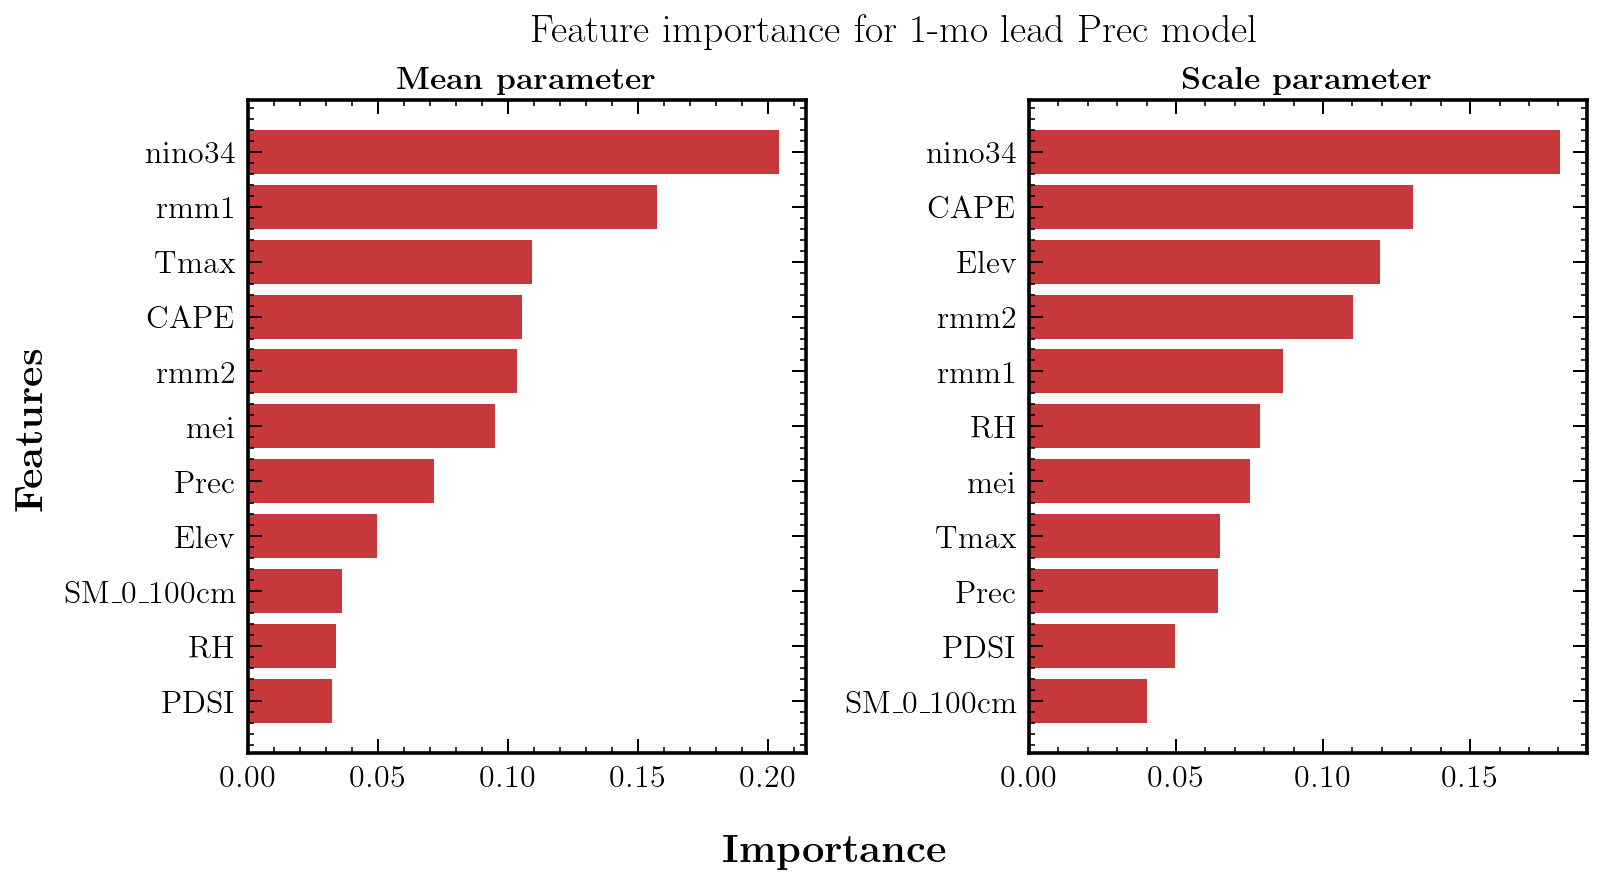

In [46]:
fig, ax= plt.subplots(1, 2, figsize= (12, 6))
fig.text(-0.01, 0.5, r'{\bf Features}', va='center', rotation= 'vertical', fontsize= 20);
fig.text(0.4, 0.01, r'{\bf Importance}', va='center', fontsize= 20);

ax[0].barh(df_loc['feature'], df_loc['importance']) #.loc[X_plot_df.groupby('reg_indx').get_group(regindx).index]
ax[0].set_title(r'{\bf Mean parameter}', va='center', fontsize= 16, pad= 10);
ax[0].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 16);

fig.subplots_adjust(wspace= 0.4)

ax[1].barh(df_scale['feature'], df_scale['importance']) #.loc[X_plot_df.groupby('reg_indx').get_group(regindx).index]
ax[1].set_title(r'{\bf Scale parameter}', va='center', fontsize= 16, pad= 10);
ax[1].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 16);
plt.suptitle(r'Feature importance for 1-mo lead %s model'%pred_var, fontsize= 20);
plt.savefig('../plots/feature_importance/%s'%pred_var + '_feature_importance_%s.pdf'%run_id, bbox_inches='tight', dpi= 300);

## Overall normalized scaling

In [ ]:
clim_df= pd.read_hdf('../data/clim_12km_1952_2023_data.h5')
clim_df['time']= clim_df['month']
clim_df.drop(columns= ['month'], inplace= True)

# Group clim_df by X and Y to get a list of all non-nan grid cells
# clim_df_groups= clim_df.dropna().groupby(['X', 'Y'], as_index= False)
# clim_df_group_keys= clim_df_groups.groups.keys()

In [ ]:
target_arr= np.append(np.append(np.append(np.arange(5, 855, 12), np.arange(5, 855, 12)+1), np.arange(5, 855, 12)+2), np.arange(5, 855, 12)+3)
lead1mons_pred_arr= target_arr - 1
lead2mons_pred_arr= target_arr - 2
lead3mons_pred_arr= target_arr - 3

lead1mons_pred_df= clim_df[clim_df['time'].isin(lead1mons_pred_arr)].dropna()[['Tmax', 'VPD', 'Prec', 'Solar', 'RH', 'CAPE', 'Tmin', 'SM_0_100cm', 'PDSI', 'FFWI_max7', 'Southness', 'Elev', 'time', 'X', 'Y', 'mei', 'nino34', 'rmm1', 'rmm2']].reset_index().drop(columns= ['index'])
lead2mons_pred_df= clim_df[clim_df['time'].isin(lead2mons_pred_arr)].dropna()[['Tmax', 'VPD', 'Prec', 'Solar', 'RH', 'CAPE', 'Tmin', 'SM_0_100cm', 'PDSI', 'FFWI_max7', 'Southness', 'Elev', 'time', 'X', 'Y', 'mei', 'nino34', 'rmm1', 'rmm2']].reset_index().drop(columns= ['index'])
lead3mons_pred_df= clim_df[clim_df['time'].isin(lead3mons_pred_arr)].dropna()[['Tmax', 'VPD', 'Prec', 'Solar', 'RH', 'CAPE', 'Tmin', 'SM_0_100cm', 'PDSI', 'FFWI_max7', 'Southness', 'Elev', 'time', 'X', 'Y', 'mei', 'nino34', 'rmm1', 'rmm2']].reset_index().drop(columns= ['index'])

tmax_target_df= clim_df[clim_df['time'].isin(target_arr)].dropna()['Tmax'].reset_index().drop(columns= ['index']).rename(columns= {'Tmax': 'Tmax_target'})
prec_target_df= clim_df[clim_df['time'].isin(target_arr)].dropna()['Prec'].reset_index().drop(columns= ['index']).rename(columns= {'Prec': 'Prec_target'})
vpd_target_df= clim_df[clim_df['time'].isin(target_arr)].dropna()['VPD'].reset_index().drop(columns= ['index']).rename(columns= {'VPD': 'VPD_target'})
ffwi_target_df= clim_df[clim_df['time'].isin(target_arr)].dropna()['FFWI_max7'].reset_index().drop(columns= ['index']).rename(columns= {'FFWI_max7': 'FFWI_target'})
tmin_target_df= clim_df[clim_df['time'].isin(target_arr)].dropna()['Tmin'].reset_index().drop(columns= ['index']).rename(columns= {'Tmin': 'Tmin_target'})

lead1mons_df= pd.concat([lead1mons_pred_df, tmax_target_df, prec_target_df, vpd_target_df, tmin_target_df, ffwi_target_df], axis= 1).replace(-999, np.nan)
#lead1mons_df['Elev']= (lead1mons_df['Elev'] - lead1mons_df['Elev'].min())/(lead1mons_df['Elev'].max() - lead1mons_df['Elev'].min())
lead2mons_df= pd.concat([lead2mons_pred_df, tmax_target_df, prec_target_df, vpd_target_df, tmin_target_df, ffwi_target_df], axis= 1).replace(-999, np.nan)
#lead2mons_df['Elev']= (lead2mons_df['Elev'] - lead2mons_df['Elev'].min())/(lead2mons_df['Elev'].max() - lead2mons_df['Elev'].min())
lead3mons_df= pd.concat([lead3mons_pred_df, tmax_target_df, prec_target_df, vpd_target_df, tmin_target_df, ffwi_target_df], axis= 1).replace(-999, np.nan)
#lead3mons_df['Elev']= (lead3mons_df['Elev'] - lead3mons_df['Elev'].min())/(lead3mons_df['Elev'].max() - lead3mons_df['Elev'].min())

In [ ]:
pred_arr_all= {'Tmax': ['Tmax', 'Solar', 'RH', 'SM_0_100cm', 'PDSI' , 'Southness', 'Elev', 'nino34', 'mei', 'rmm1', 'rmm2'], \
               'Prec': ['Prec', 'Tmax', 'Solar', 'RH', 'SM_0_100cm', 'PDSI', 'CAPE', 'Southness', 'Elev', 'mei', 'nino34', 'rmm1', 'rmm2'], \
               'VPD': ['VPD', 'Tmax', 'Prec', 'Solar', 'RH', 'SM_0_100cm', 'PDSI', 'Southness', 'Elev', 'mei', 'nino34', 'rmm1', 'rmm2'], \
               'FFWI': ['FFWI_max7', 'Tmax', 'Prec', 'Solar', 'RH', 'SM_0_100cm', 'PDSI', 'Southness', 'Elev', 'mei', 'nino34', 'rmm1', 'rmm2'], \
               'Tmin': ['Tmin', 'Tmax', 'Prec', 'Solar', 'RH', 'SM_0_100cm', 'PDSI', 'Southness', 'Elev', 'mei', 'nino34', 'rmm1', 'rmm2']}
pred_arr_dynamic= {'Tmax': ['Tmax', 'Solar', 'RH', 'SM_0_100cm', 'PDSI'], 'Prec': ['Prec', 'Tmax', 'Solar', 'RH', 'SM_0_100cm', 'PDSI', 'CAPE'], \
                   'VPD': ['VPD', 'Tmax', 'Prec', 'Solar', 'RH', 'SM_0_100cm', 'PDSI'], 'FFWI': ['FFWI_max7', 'Tmax', 'Prec', 'Solar', 'RH', 'SM_0_100cm', 'PDSI'], \
                    'Tmin': ['Tmin', 'Tmax', 'Prec', 'Solar', 'RH', 'SM_0_100cm', 'PDSI']} #'nino34'

#### NGBoost training

In [ ]:
pred_var_arr= ['Tmax', 'Prec', 'VPD', 'FFWI', 'Tmin'] 
run_id= 'normalized_lead3mo'
if run_id == 'normalized_lead1mo':
    leadmonsdf= lead1mons_df
    leadsmons_pred_arr= np.sort(lead1mons_pred_arr)
elif run_id == 'normalized_lead2mo':
    leadmonsdf= lead2mons_df
    leadsmons_pred_arr= np.sort(lead2mons_pred_arr)
elif run_id == 'normalized_lead3mo':
    leadmonsdf= lead3mons_df
    leadsmons_pred_arr= np.sort(lead3mons_pred_arr)

for pred_var in tqdm(pred_var_arr):
    X= leadmonsdf[pred_arr_all[pred_var]][leadmonsdf.time < 700] # train+val:test :: 80:20
    #X_scaled= X - X.mean(axis= 0, skipna= True)/X.std(axis= 0, skipna= True)
    X_scaled= pd.concat([(X[pred_arr_dynamic[pred_var]] - X[pred_arr_dynamic[pred_var]].mean(axis= 0, skipna= True))/X[pred_arr_dynamic[pred_var]].std(axis= 0, skipna= True), \
                                            X[['Southness', 'Elev', 'nino34', 'mei', 'rmm1', 'rmm2']]], axis= 1).replace(np.nan, 0)
    Y= leadmonsdf.iloc[X_scaled.index][pred_var + '_target']
    Y_scaled= (Y - Y.mean())/Y.std()
    X_train, X_val, Y_train, Y_val = train_test_split(X_scaled, Y_scaled, test_size=0.2)

    poly = PolynomialFeatures(1)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.fit_transform(X_val)

    ngb = NGBRegressor(minibatch_frac= 0.1, random_state= 42).fit(X_train_poly, Y_train)
    Y_preds = ngb.predict(X_val_poly)
    Y_dists = ngb.pred_dist(X_val_poly)

    # test Mean Squared Error
    test_MSE = mean_squared_error(Y_preds, Y_val)
    print('Test MSE', test_MSE)

    # test Negative Log Likelihood
    test_NLL = -Y_dists.logpdf(Y_val).mean()
    print('Test NLL', test_NLL)

    ngb_path= 'ngb_%s'%pred_var + '_%s'%run_id +'_mb_%.2f.p'%(0.1)
    file_path = Path.home()/'Desktop/seasonal_fire_pred/sav_files/ngb_mods'/ngb_path
    with file_path.open("wb") as f:
        pickle.dump(ngb, f)

  0%|          | 0/5 [00:00<?, ?it/s]

[iter 0] loss=1.4216 val_loss=0.0000 scale=1.0000 norm=1.0017
[iter 100] loss=1.1221 val_loss=0.0000 scale=2.0000 norm=1.5488
[iter 200] loss=0.9487 val_loss=0.0000 scale=1.0000 norm=0.7052
[iter 300] loss=0.8443 val_loss=0.0000 scale=1.0000 norm=0.6890
[iter 400] loss=0.7971 val_loss=0.0000 scale=1.0000 norm=0.6856


 20%|██        | 1/5 [19:08<1:16:32, 1148.16s/it]

Test MSE 0.31194589932254563
Test NLL 0.7662181422981377
[iter 0] loss=1.4274 val_loss=0.0000 scale=1.0000 norm=1.0067
[iter 100] loss=1.3276 val_loss=0.0000 scale=2.0000 norm=1.8695
[iter 200] loss=1.2832 val_loss=0.0000 scale=1.0000 norm=0.9208
[iter 300] loss=1.2631 val_loss=0.0000 scale=1.0000 norm=0.9157
[iter 400] loss=1.2501 val_loss=0.0000 scale=1.0000 norm=0.9134


 40%|████      | 2/5 [40:50<1:01:56, 1238.98s/it]

Test MSE 0.8038429940253712
Test NLL 1.2334614396664438
[iter 0] loss=1.4209 val_loss=0.0000 scale=1.0000 norm=1.0007
[iter 100] loss=1.0710 val_loss=0.0000 scale=1.0000 norm=0.7451
[iter 200] loss=0.9225 val_loss=0.0000 scale=1.0000 norm=0.6961
[iter 300] loss=0.8475 val_loss=0.0000 scale=1.0000 norm=0.6890
[iter 400] loss=0.8052 val_loss=0.0000 scale=1.0000 norm=0.6897


 60%|██████    | 3/5 [1:03:06<42:46, 1283.09s/it]

Test MSE 0.32620671918017957
Test NLL 0.7756398831333686
[iter 0] loss=1.4224 val_loss=0.0000 scale=1.0000 norm=1.0024
[iter 100] loss=1.1598 val_loss=0.0000 scale=1.0000 norm=0.8051
[iter 200] loss=1.0298 val_loss=0.0000 scale=2.0000 norm=1.5540
[iter 300] loss=0.9963 val_loss=0.0000 scale=1.0000 norm=0.7767
[iter 400] loss=0.9779 val_loss=0.0000 scale=1.0000 norm=0.7749


 80%|████████  | 4/5 [1:25:24<21:44, 1304.92s/it]

Test MSE 0.46743999391838104
Test NLL 0.964796314799495
[iter 0] loss=1.4201 val_loss=0.0000 scale=1.0000 norm=1.0001
[iter 100] loss=1.1076 val_loss=0.0000 scale=1.0000 norm=0.7697
[iter 200] loss=0.9587 val_loss=0.0000 scale=1.0000 norm=0.7132
[iter 300] loss=0.8738 val_loss=0.0000 scale=1.0000 norm=0.6981
[iter 400] loss=0.8313 val_loss=0.0000 scale=1.0000 norm=0.6969


100%|██████████| 5/5 [1:47:46<00:00, 1293.28s/it]

Test MSE 0.33135431003356447
Test NLL 0.8006579498819475


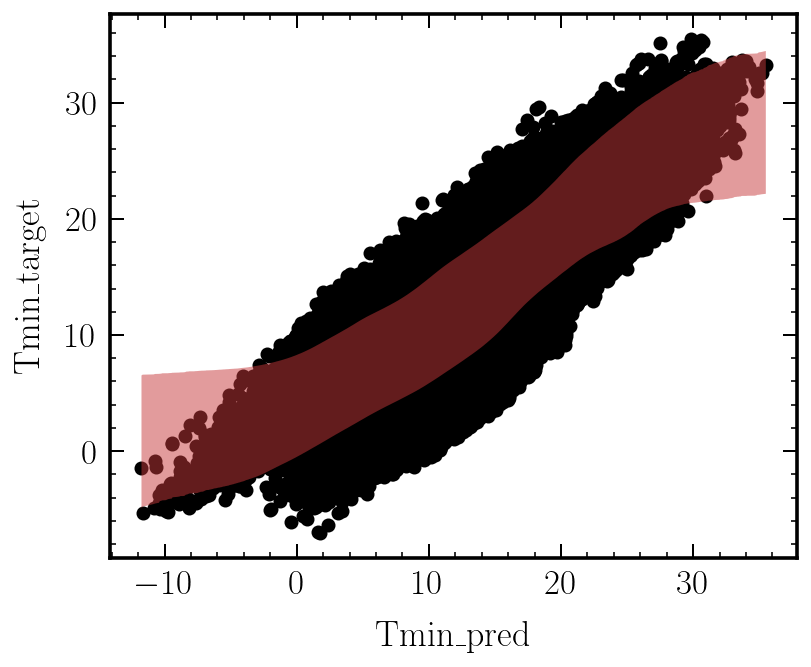

In [ ]:
plt.scatter(X_val_poly[:, 1]*X[pred_var].std(axis= 0, skipna= True) + X[pred_var].mean(axis= 0, skipna= True), Y_val*Y.std() + Y.mean(), color= 'black')

Y_pred_low_1sig= (Y_dists.params['loc'] - 1.96 * Y_dists.params['scale'])*Y.std() + Y.mean()
Y_pred_high_1sig= (Y_dists.params['loc'] + 1.96 * Y_dists.params['scale'])*Y.std() + Y.mean()
plt.fill_between(np.sort(X_val_poly[:, 1]*X[pred_var].std(axis= 0, skipna= True) + X[pred_var].mean(axis= 0, skipna= True)), np.sort(Y_pred_low_1sig), \
                                                np.sort(Y_pred_high_1sig), alpha= 0.5)
plt.xlabel(r'%s_pred'%pred_var, fontsize= 18)
plt.ylabel(r'%s_target'%pred_var, fontsize= 18)
plt.show()

#### NGBoost predictions 

In [ ]:
pred_var_arr= ['Tmax', 'Prec', 'VPD', 'FFWI', 'Tmin']
run_id= 'normalized_lead3mo'
mb_frac= 0.1

tmax_xr= xarray.open_dataarray('../data/12km/climate/primary/tmax.nc') # for getting the lat/lon coordinates
ind_nan= clim_df.groupby('time').get_group(0).dropna().index
len_xcoord= len(tmax_xr.X)
len_ycoord= len(tmax_xr.Y)

for pred_var in tqdm(pred_var_arr):
    ngb_path= 'ngb_%s'%pred_var + '_%s'%run_id + '_mb_%.2f.p'%(mb_frac)
    file_path = Path.home()/'Desktop/seasonal_fire_pred/sav_files/ngb_mods'/ngb_path
    with file_path.open("rb") as f:
        ngb= pickle.load(f)

    pred_list= deepcopy(pred_arr_all[pred_var])
    pred_list.extend(['time', 'X', 'Y'])

    X= leadmonsdf[pred_list][leadmonsdf.time < 700]
    Y= leadmonsdf.iloc[X.index][pred_var + '_target'] # ensure that Y is always the target variable and not a predictor

    Y_dist_loc= []
    Y_dist_scale= []
    Y_obs= []

    leadmonsdf_groups= leadmonsdf.groupby(['time'], as_index= False)
    for m in leadsmons_pred_arr:
        X_test= leadmonsdf_groups.get_group(m)[pred_list]
        #X_test_scaled= X_test - X.mean(axis= 0, skipna= True)/X.std(axis= 0, skipna= True)
        X_test_scaled= pd.concat([(X_test[pred_arr_dynamic[pred_var]] - X[pred_arr_dynamic[pred_var]].mean(axis= 0, skipna= True))/X[pred_arr_dynamic[pred_var]].std(axis= 0, skipna= True), \
                                                X_test[['Southness', 'Elev', 'nino34', 'mei', 'rmm1', 'rmm2']]], axis= 1).replace(np.nan, 0)
        poly = PolynomialFeatures(1)
        X_test_poly= poly.fit_transform(X_test_scaled)
        
        tmplocarr= np.ones(len_xcoord*len_ycoord)*np.nan
        tmpsigarr= np.ones(len_xcoord*len_ycoord)*np.nan
        tmpobsarr= np.ones(len_xcoord*len_ycoord)*np.nan
        tmplocarr[ind_nan]= ngb.pred_dist(X_test_poly).params['loc']*Y.std() + Y.mean()
        tmpsigarr[ind_nan]= ngb.pred_dist(X_test_poly).params['scale']*Y.std()
        tmpobsarr[ind_nan]= leadmonsdf_groups.get_group(m)[pred_var + '_target']

        Y_dist_loc.append(tmplocarr)
        Y_dist_scale.append(tmpsigarr)
        Y_obs.append(tmpobsarr)

    # convert Y_dist_loc and Y_dist_scale to xarray with X and Y dimensions equal to len_ycoord and len_xcoord
    Y_dist_loc_xr= xarray.DataArray(np.array(Y_dist_loc).reshape(len(target_arr), len_ycoord, len_xcoord), \
                                            coords= {'time': np.sort(target_arr), 'Y': tmax_xr.Y, 'X': tmax_xr.X}, dims= ['time', 'Y', 'X'])
    Y_dist_scale_xr= xarray.DataArray(np.array(Y_dist_scale).reshape(len(target_arr), len_ycoord, len_xcoord), \
                                            coords= {'time': np.sort(target_arr), 'Y': tmax_xr.Y, 'X': tmax_xr.X}, dims= ['time', 'Y', 'X'])
    #Y_obs_xr= xarray.DataArray(np.array(Y_obs).reshape(len(target_arr), len_ycoord, len_xcoord), \
    #                                        coords= {'time': np.sort(target_arr), 'Y': tmax_xr.Y, 'X': tmax_xr.X}, dims= ['time', 'Y', 'X'])

    Y_dist_loc_xr.to_netcdf('../sav_files/ngb_pred_files/%s'%pred_var + '_%s'%mb_frac + '_%s_ngb_loc.nc'%run_id)
    Y_dist_scale_xr.to_netcdf('../sav_files/ngb_pred_files/%s'%pred_var + '_%s'%mb_frac + '_%s_ngb_scale.nc'%run_id)
    #Y_obs_xr.to_netcdf('../sav_files/ngb_pred_files/%s'%pred_var + '_obs.nc')

100%|██████████| 5/5 [37:35<00:00, 451.17s/it]
